In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import dtw

In [50]:
data_wear_01_15 = pd.read_excel("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/Annotated_WEAR_7001_7015_deID.xlsx", header = 7)
data_wear_16_30 = pd.read_excel("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/Annotated_WEAR_7016_7030_deID.xlsx", header = 7)

In [51]:
# Get rid of normalization summarized rows

data_wear_01_15_remove_normalized = data_wear_01_15.dropna(subset = ['PT_ID'])
data_wear_16_30_remove_normalized = data_wear_16_30.dropna(subset = ['PT_ID'])

In [52]:
df = pd.concat([data_wear_01_15_remove_normalized, data_wear_16_30_remove_normalized], axis=0, ignore_index=True)

In [53]:
df_extract = df[['PT_ID','Date of Sample','Agent (JNJ/BMS/Caribou)' ,'Patient experienced CRS at any point (Yes/No)','CRS on date (0 No, 1 Yes)']]
df_extract['Cytokine Available Y/N'] = "Y"
df_extract['Wearable Available Y/N'] = "Y"
df_extract.PT_ID = df_extract.PT_ID.astype(float).astype(int).astype(str)
df_extract.loc[df_extract['PT_ID'] == '7030', 'Wearable Available Y/N'] = 'N'




/var/folders/9q/_q_h4th94vj56dq6c3yv3gj80000gn/T/ipykernel_50269/3554501905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extract['Cytokine Available Y/N'] = "Y"
/var/folders/9q/_q_h4th94vj56dq6c3yv3gj80000gn/T/ipykernel_50269/3554501905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extract['Wearable Available Y/N'] = "Y"
/var/folders/9q/_q_h4th94vj56dq6c3yv3gj80000gn/T/ipykernel_50269/3554501905.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [54]:
df_extract[df_extract.PT_ID == '7026']

,PT_ID,Date of Sample,Agent (JNJ/BMS/Caribou),Patient experienced CRS at any point (Yes/No),"CRS on date (0 No, 1 Yes)",Cytokine Available Y/N,Wearable Available Y/N
368,7026,2023-09-08,JNJ,Yes,0.0,Y,Y
369,7026,2023-09-09,JNJ,Yes,0.0,Y,Y
370,7026,2023-09-09,JNJ,Yes,0.0,Y,Y
371,7026,2023-09-11,JNJ,Yes,0.0,Y,Y


In [55]:
import pandas as pd

# Assuming df_extract is your DataFrame
# First, filter rows where CRS on date is 1
crs_onset_dates = (
    df_extract[df_extract['CRS on date (0 No, 1 Yes)'] == 1]
    .groupby('PT_ID')['Date of Sample']
    .min()
    .reset_index()
    .rename(columns={'Date of Sample': 'CRS onset date'})
)

# Merge the onset dates back into the original DataFrame
df_extract = df_extract.merge(crs_onset_dates, on='PT_ID', how='left')

# Display the updated DataFrame
print(df_extract)


    PT_ID Date of Sample Agent (JNJ/BMS/Caribou)  \
0    7001     2022-10-21                     BMS   
1    7001     2022-10-22                     BMS   
2    7001     2022-10-22                     BMS   
3    7001     2022-10-23                     BMS   
4    7001     2022-10-24                     BMS   
..    ...            ...                     ...   
429  7030     2023-11-27                     JNJ   
430  7030     2023-11-28                     JNJ   
431  7030     2023-11-29                     JNJ   
432  7030     2023-11-30                     JNJ   
433  7030     2023-12-01                     JNJ   

    Patient experienced CRS at any point (Yes/No)  CRS on date (0 No, 1 Yes)  \
0                                             Yes                        1.0   
1                                             Yes                        1.0   
2                                             Yes                        1.0   
3                                             Yes      

In [56]:
df_extract.loc[df_extract['PT_ID'] == '7026', 'CRS onset date'] = '2023-09-14'

In [57]:
# Drop 'Date of Sample' and 'CRS on date (0 No, 1 Yes)' columns
df_extract = df_extract.drop(columns=['Date of Sample', 'CRS on date (0 No, 1 Yes)'])

# Deduplicate so each patient has only one row
df_extract = df_extract.drop_duplicates(subset='PT_ID')
df_extract = df_extract.sort_values(by = ['PT_ID'])
# Display the final DataFrame
print(df_extract)


    PT_ID Agent (JNJ/BMS/Caribou)  \
0    7001                     BMS   
60   7002                     BMS   
77   7003       CC-95266 (GPRC5D)   
119  7004                     JNJ   
172  7005                 JNJ OOS   
12   7006                     BMS   
96   7007                     JNJ   
135  7008                 BMS EAP   
26   7009                     BMS   
186  7010                     BMS   
44   7011                     JNJ   
107  7012                     JNJ   
218  7013        CB-011 (Caribou)   
152  7014                     BMS   
201  7015       CC-95266 (GPRC5D)   
224  7016                     JNJ   
236  7017                     JNJ   
250  7018                     BMS   
266  7019                     JNJ   
278  7020                     JNJ   
290  7021                     JNJ   
304  7022                     JNJ   
318  7023                     JNJ   
333  7024                     JNJ   
348  7025                     BMS   
368  7026                     JNJ   
3

In [58]:
ID_match = pd.read_csv("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/ID_match")
ID_match[["CH_ID", "Olink_ID"]] = ID_match["CH_ID\tOlink_ID"].str.split("\t", expand = True)
ID_match['Olink_ID'] = ID_match["Olink_ID"].str.extract(r"(\d+)$")
ID_match = ID_match.drop(columns=["CH_ID\tOlink_ID"])
ID_match

,CH_ID,Olink_ID
0,1e1acd61-e506-4d15-b442-b84b0236d2be,7001
1,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,7002
2,f90f3710-cbf9-4a8e-92c2-e6144b89bcff,7003
3,46a8959e-a3ef-49c4-99b4-6abd2341bed8,7004
4,2e5a988f-4e78-4648-ba15-60c43e33f72e,7005
5,7af1b94f-d193-4220-9437-d84a329a7e88,7006
6,65038550-1e25-4fd5-934a-7574c55ea662,7007
7,4f191869-d131-44f1-b6db-3d7dbfc77abd,7008
8,398a8fc9-e1ef-4dfd-8b72-7a93b4fe777c,7009
9,38a0fa6b-acf9-4204-a4a4-ea06da443987,7010


In [59]:
# Merging the datasets on PT_ID
df_extract = pd.merge(df_extract, ID_match, left_on='PT_ID',right_on="Olink_ID", how='left')
df_extract

,PT_ID,Agent (JNJ/BMS/Caribou),Patient experienced CRS at any point (Yes/No),Cytokine Available Y/N,Wearable Available Y/N,CRS onset date,CH_ID,Olink_ID
0,7001,BMS,Yes,Y,Y,2022-10-21,1e1acd61-e506-4d15-b442-b84b0236d2be,7001
1,7002,BMS,Yes,Y,Y,2022-10-28,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,7002
2,7003,CC-95266 (GPRC5D),Yes,Y,Y,2022-11-11,f90f3710-cbf9-4a8e-92c2-e6144b89bcff,7003
3,7004,JNJ,No,Y,Y,NaT,46a8959e-a3ef-49c4-99b4-6abd2341bed8,7004
4,7005,JNJ OOS,Yes,Y,Y,2022-12-14,2e5a988f-4e78-4648-ba15-60c43e33f72e,7005
5,7006,BMS,No,Y,Y,NaT,7af1b94f-d193-4220-9437-d84a329a7e88,7006
6,7007,JNJ,Yes,Y,Y,2023-01-14,65038550-1e25-4fd5-934a-7574c55ea662,7007
7,7008,BMS EAP,Yes,Y,Y,2023-01-24,4f191869-d131-44f1-b6db-3d7dbfc77abd,7008
8,7009,BMS,Yes,Y,Y,2023-01-25,398a8fc9-e1ef-4dfd-8b72-7a93b4fe777c,7009
9,7010,BMS,Yes,Y,Y,2023-02-01,38a0fa6b-acf9-4204-a4a4-ea06da443987,7010


In [60]:
df_extract = df_extract.drop(columns=['Olink_ID'])
df_extract

,PT_ID,Agent (JNJ/BMS/Caribou),Patient experienced CRS at any point (Yes/No),Cytokine Available Y/N,Wearable Available Y/N,CRS onset date,CH_ID
0,7001,BMS,Yes,Y,Y,2022-10-21,1e1acd61-e506-4d15-b442-b84b0236d2be
1,7002,BMS,Yes,Y,Y,2022-10-28,9e9e94c7-01a6-4840-8240-eaa4c13a95ca
2,7003,CC-95266 (GPRC5D),Yes,Y,Y,2022-11-11,f90f3710-cbf9-4a8e-92c2-e6144b89bcff
3,7004,JNJ,No,Y,Y,NaT,46a8959e-a3ef-49c4-99b4-6abd2341bed8
4,7005,JNJ OOS,Yes,Y,Y,2022-12-14,2e5a988f-4e78-4648-ba15-60c43e33f72e
5,7006,BMS,No,Y,Y,NaT,7af1b94f-d193-4220-9437-d84a329a7e88
6,7007,JNJ,Yes,Y,Y,2023-01-14,65038550-1e25-4fd5-934a-7574c55ea662
7,7008,BMS EAP,Yes,Y,Y,2023-01-24,4f191869-d131-44f1-b6db-3d7dbfc77abd
8,7009,BMS,Yes,Y,Y,2023-01-25,398a8fc9-e1ef-4dfd-8b72-7a93b4fe777c
9,7010,BMS,Yes,Y,Y,2023-02-01,38a0fa6b-acf9-4204-a4a4-ea06da443987


In [61]:
df_extract

,PT_ID,Agent (JNJ/BMS/Caribou),Patient experienced CRS at any point (Yes/No),Cytokine Available Y/N,Wearable Available Y/N,CRS onset date,CH_ID
0,7001,BMS,Yes,Y,Y,2022-10-21,1e1acd61-e506-4d15-b442-b84b0236d2be
1,7002,BMS,Yes,Y,Y,2022-10-28,9e9e94c7-01a6-4840-8240-eaa4c13a95ca
2,7003,CC-95266 (GPRC5D),Yes,Y,Y,2022-11-11,f90f3710-cbf9-4a8e-92c2-e6144b89bcff
3,7004,JNJ,No,Y,Y,NaT,46a8959e-a3ef-49c4-99b4-6abd2341bed8
4,7005,JNJ OOS,Yes,Y,Y,2022-12-14,2e5a988f-4e78-4648-ba15-60c43e33f72e
5,7006,BMS,No,Y,Y,NaT,7af1b94f-d193-4220-9437-d84a329a7e88
6,7007,JNJ,Yes,Y,Y,2023-01-14,65038550-1e25-4fd5-934a-7574c55ea662
7,7008,BMS EAP,Yes,Y,Y,2023-01-24,4f191869-d131-44f1-b6db-3d7dbfc77abd
8,7009,BMS,Yes,Y,Y,2023-01-25,398a8fc9-e1ef-4dfd-8b72-7a93b4fe777c
9,7010,BMS,Yes,Y,Y,2023-02-01,38a0fa6b-acf9-4204-a4a4-ea06da443987


In [62]:
Nurse_data = pd.read_csv("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/Updated_Nurse_Data_with_UTC_Timestamp (1).csv")
Nurse_data.head(5)

,patient id,training_data,Enrolled,CAR-T infusion date Morning time,CAR-T infusion date,CAR-T product,First CRS timestamp (by RN),CRS marker at 1st timesamp,Subsequent CRS timestamps (by RN) and markrs,CRS Grade (max),CRS intervention,ICANS Grade,Standardized CAR-T product,Standardized First CRS timestamp (by RN) and subsequent,Temperature,SpO2,BP,HR,Standardized First CRS timestamp (by RN) and subsequent (UTC)
0,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,1,10/25/22,2022-10-25 08:58:00,10/25/22,Abecma,10/26/22 at 13:00,"Temp 100F, SpO2 WNL, BP WNL","10/28/22 at 15:22 (100.9F), 10/29/22 at 00:22 ...",1,"IVF, Tocilizumab x 1 on (10/29/22)",0,Abecma,10/26/22 13:00,100F,WNL,WNL,WNL,2022-10-26 13:00:00+00:00
1,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,1,10/25/22,2022-10-25 08:58:00,NaN,Abecma,10/26/22 at 13:00,"Temp 100F, SpO2 WNL, BP WNL","10/28/22 at 15:22 (100.9F), 10/29/22 at 00:22 ...",1,"IVF, Tocilizumab x 1 on (10/29/22)",0,Abecma,10/28/22 15:22,100.9F,WNL,WNL,WNL,2022-10-28 15:22:00+00:00
2,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,1,10/25/22,2022-10-25 08:58:00,NaN,Abecma,10/26/22 at 13:00,"Temp 100F, SpO2 WNL, BP WNL","10/28/22 at 15:22 (100.9F), 10/29/22 at 00:22 ...",1,"IVF, Tocilizumab x 1 on (10/29/22)",0,Abecma,10/29/22 00:22,100.9F,WNL,WNL,WNL,2022-10-29 00:22:00+00:00
3,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,1,10/25/22,2022-10-25 08:58:00,NaN,Abecma,10/26/22 at 13:00,"Temp 100F, SpO2 WNL, BP WNL","10/28/22 at 15:22 (100.9F), 10/29/22 at 00:22 ...",1,"IVF, Tocilizumab x 1 on (10/29/22)",0,Abecma,10/29/22 15:23,100.9F,WNL,WNL,WNL,2022-10-29 15:23:00+00:00
4,7af1b94f-d193-4220-9437-d84a329a7e88,1,12/14/22,2022-12-14 07:06:00,12/14/22,Abecma,NaN,NaN,NaN,0,"IVF, Tocilizumab x 1 on (10/29/22)",0,Abecma,NaN,WNL,WNL,WNL,WNL,NaN


In [63]:
Nurse_data = pd.merge(Nurse_data, ID_match, left_on="patient id", right_on="CH_ID",how="left")
Nurse_data.head(5)

,patient id,training_data,Enrolled,CAR-T infusion date Morning time,CAR-T infusion date,CAR-T product,First CRS timestamp (by RN),CRS marker at 1st timesamp,Subsequent CRS timestamps (by RN) and markrs,CRS Grade (max),...,ICANS Grade,Standardized CAR-T product,Standardized First CRS timestamp (by RN) and subsequent,Temperature,SpO2,BP,HR,Standardized First CRS timestamp (by RN) and subsequent (UTC),CH_ID,Olink_ID
0,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,1,10/25/22,2022-10-25 08:58:00,10/25/22,Abecma,10/26/22 at 13:00,"Temp 100F, SpO2 WNL, BP WNL","10/28/22 at 15:22 (100.9F), 10/29/22 at 00:22 ...",1,...,0,Abecma,10/26/22 13:00,100F,WNL,WNL,WNL,2022-10-26 13:00:00+00:00,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,7002
1,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,1,10/25/22,2022-10-25 08:58:00,NaN,Abecma,10/26/22 at 13:00,"Temp 100F, SpO2 WNL, BP WNL","10/28/22 at 15:22 (100.9F), 10/29/22 at 00:22 ...",1,...,0,Abecma,10/28/22 15:22,100.9F,WNL,WNL,WNL,2022-10-28 15:22:00+00:00,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,7002
2,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,1,10/25/22,2022-10-25 08:58:00,NaN,Abecma,10/26/22 at 13:00,"Temp 100F, SpO2 WNL, BP WNL","10/28/22 at 15:22 (100.9F), 10/29/22 at 00:22 ...",1,...,0,Abecma,10/29/22 00:22,100.9F,WNL,WNL,WNL,2022-10-29 00:22:00+00:00,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,7002
3,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,1,10/25/22,2022-10-25 08:58:00,NaN,Abecma,10/26/22 at 13:00,"Temp 100F, SpO2 WNL, BP WNL","10/28/22 at 15:22 (100.9F), 10/29/22 at 00:22 ...",1,...,0,Abecma,10/29/22 15:23,100.9F,WNL,WNL,WNL,2022-10-29 15:23:00+00:00,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,7002
4,7af1b94f-d193-4220-9437-d84a329a7e88,1,12/14/22,2022-12-14 07:06:00,12/14/22,Abecma,NaN,NaN,NaN,0,...,0,Abecma,NaN,WNL,WNL,WNL,WNL,NaN,7af1b94f-d193-4220-9437-d84a329a7e88,7006


In [64]:
Nurse_data.columns

Index(['patient id', 'training_data', 'Enrolled ',
       'CAR-T infusion date Morning time', 'CAR-T infusion date',
       'CAR-T product', 'First CRS timestamp (by RN) ',
       'CRS marker at 1st timesamp',
       'Subsequent CRS timestamps (by RN) and markrs ', 'CRS Grade (max)',
       'CRS intervention ', 'ICANS Grade ', 'Standardized CAR-T product',
       'Standardized First CRS timestamp (by RN) and subsequent',
       'Temperature', 'SpO2', 'BP', 'HR',
       'Standardized First CRS timestamp (by RN) and subsequent (UTC)',
       'CH_ID', 'Olink_ID'],
      dtype='object')

In [65]:

Nurse_data_selected = Nurse_data[['Olink_ID','First CRS timestamp (by RN) ']]
Nurse_data_selected


,Olink_ID,First CRS timestamp (by RN)
0,7002,10/26/22 at 13:00
1,7002,10/26/22 at 13:00
2,7002,10/26/22 at 13:00
3,7002,10/26/22 at 13:00
4,7006,NaN
...,...,...
110,NaN,11/3/21 at 08:07
111,NaN,10/19/21 at 23:48
112,NaN,7/18/21 at 18:00
113,NaN,9/29/21 at 17:28


In [66]:
temp = df_extract.copy()

In [67]:
df_extract = temp.copy()
Nurse_data_selected = Nurse_data_selected.drop_duplicates()
df_extract = pd.merge(df_extract, Nurse_data_selected, left_on="PT_ID", right_on='Olink_ID')
df_extract = df_extract.drop(columns = ['Olink_ID','CRS onset date'])

In [68]:
df_extract['First CRS Date'] = pd.to_datetime(df_extract['First CRS timestamp (by RN) '], errors='coerce').dt.date

/var/folders/9q/_q_h4th94vj56dq6c3yv3gj80000gn/T/ipykernel_50269/137211789.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_extract['First CRS Date'] = pd.to_datetime(df_extract['First CRS timestamp (by RN) '], errors='coerce').dt.date


In [69]:
df_extract

,PT_ID,Agent (JNJ/BMS/Caribou),Patient experienced CRS at any point (Yes/No),Cytokine Available Y/N,Wearable Available Y/N,CH_ID,First CRS timestamp (by RN),First CRS Date
0,7001,BMS,Yes,Y,Y,1e1acd61-e506-4d15-b442-b84b0236d2be,1/21/22 at 23:30,2022-01-21
1,7002,BMS,Yes,Y,Y,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,10/26/22 at 13:00,2022-10-26
2,7003,CC-95266 (GPRC5D),Yes,Y,Y,f90f3710-cbf9-4a8e-92c2-e6144b89bcff,11/11/2022 at 00:00,2022-11-11
3,7004,JNJ,No,Y,Y,46a8959e-a3ef-49c4-99b4-6abd2341bed8,NaN,NaT
4,7005,JNJ OOS,Yes,Y,Y,2e5a988f-4e78-4648-ba15-60c43e33f72e,12/14/22 at 13:36,2022-12-14
5,7006,BMS,No,Y,Y,7af1b94f-d193-4220-9437-d84a329a7e88,NaN,NaT
6,7007,JNJ,Yes,Y,Y,65038550-1e25-4fd5-934a-7574c55ea662,1/14/23 at 23:00,2023-01-14
7,7008,BMS EAP,Yes,Y,Y,4f191869-d131-44f1-b6db-3d7dbfc77abd,1/23/23 at 23:41,2023-01-23
8,7009,BMS,Yes,Y,Y,398a8fc9-e1ef-4dfd-8b72-7a93b4fe777c,1/25/23 at 04:20,2023-01-25
9,7010,BMS,Yes,Y,Y,38a0fa6b-acf9-4204-a4a4-ea06da443987,2/1/23 at 11:16,2023-02-01


In [70]:
df_extract.to_excel("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/working_patients.xlsx")


In [71]:
df[df['PT_ID'] == 7026]

,Wearable Device ID,Sample ID,PT_ID,Agent (JNJ/BMS/Caribou),Date of CAR-T infusion,DOB,Age,Date of Sample,Days in relation to CAR-T infusion,Patient experienced CRS at any point (Yes/No),...,QC Deviation from median.1,Patient experienced ICANS at any point (Yes/No),"ICANs on date (0 -no, 1 yes)",Abs Monocyte,Abs Neutrophil,Abs Lymphocyte,Weight at time of infusion,Total Cells infused (x10^6),DOP,Date of last response assesment
368,NaN,WEAR_7026_V1,7026.0,JNJ,2023-09-08 00:00:00,NaT,NaN,2023-09-08,0,Yes,...,-0.00900,No,0.0,0.1000,2.60,0.1000,90.5,63.35,NaN,1/30/2024
369,NaN,WEAR_7026_V2,7026.0,JNJ,2023-09-08 00:00:00,NaT,NaN,2023-09-09,1,Yes,...,0.12266,No,0.0,0.2340,2.21,0.0442,90.5,63.35,NaN,1/30/2024
370,NaN,WEAR_7026_V3,7026.0,JNJ,2023-09-08 00:00:00,NaT,NaN,2023-09-09,1,Yes,...,0.05418,No,0.0,0.2340,2.21,0.0442,90.5,63.35,NaN,1/30/2024
371,NaN,WEAR_7026_V4,7026.0,JNJ,2023-09-08 00:00:00,NaT,NaN,2023-09-11,3,Yes,...,0.00000,No,0.0,0.0616,0.96,0.0490,90.5,63.35,NaN,1/30/2024


In [72]:
df.isna().sum().sort_values(ascending=False).head(10)

Wearable Device ID                                 434
DOP                                                415
Date of PD (1_24_24)                               392
Date of Last Response Assess if No PD (1_24_24)    252
Date of last response assesment                    243
Abs Lymphocyte                                     235
Abs Neutrophil                                     235
Abs Monocyte                                       235
Total Cells infused (x10^6)                        224
Weight at time of infusion                         224
dtype: int64

In [73]:
df

,Wearable Device ID,Sample ID,PT_ID,Agent (JNJ/BMS/Caribou),Date of CAR-T infusion,DOB,Age,Date of Sample,Days in relation to CAR-T infusion,Patient experienced CRS at any point (Yes/No),...,QC Deviation from median.1,Patient experienced ICANS at any point (Yes/No),"ICANs on date (0 -no, 1 yes)",Abs Monocyte,Abs Neutrophil,Abs Lymphocyte,Weight at time of infusion,Total Cells infused (x10^6),DOP,Date of last response assesment
0,NaN,WEAR_7001_V1,7001.0,BMS,10/21/22,1939-11-16,82.986301,2022-10-21,0,Yes,...,0.047985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,WEAR_7001_CRS,7001.0,BMS,10/21/22,1939-11-16,82.986301,2022-10-22,1,Yes,...,0.129946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,WEAR_7001_V6,7001.0,BMS,10/21/22,1939-11-16,82.986301,2022-10-22,1,Yes,...,0.127925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,WEAR_7001_V7,7001.0,BMS,10/21/22,1939-11-16,82.986301,2022-10-23,2,Yes,...,-0.053275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,WEAR_7001_V8,7001.0,BMS,10/21/22,1939-11-16,82.986301,2022-10-24,3,Yes,...,-0.065034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,NaN,WEAR_7030_V11,7030.0,JNJ,2023-11-18 00:00:00,NaT,NaN,2023-11-27,9,Yes,...,-0.177675,No,0.0,0.2484,0.15,1.728,76.6,53.62,NaN,1/30/2024
430,NaN,WEAR_7030_V12,7030.0,JNJ,2023-11-18 00:00:00,NaT,NaN,2023-11-28,10,Yes,...,-0.153385,No,0.0,0.3780,0.12,2.730,76.6,53.62,NaN,1/30/2024
431,NaN,WEAR_7030_V13,7030.0,JNJ,2023-11-18 00:00:00,NaT,NaN,2023-11-29,11,Yes,...,0.044565,No,0.0,0.3600,0.19,1.080,76.6,53.62,NaN,1/30/2024
432,NaN,WEAR_7030_V14,7030.0,JNJ,2023-11-18 00:00:00,NaT,NaN,2023-11-30,12,Yes,...,-0.120686,No,0.0,0.4590,0.36,0.646,76.6,53.62,NaN,1/30/2024


There are three data source - wearable data, nurse collected data, and the wearable data/ biomarker data collected after CRS infusion  

Time line:  
    Wearable data: before CRS infusion:  
    Nurse collected data: some time during/before/after CAR-T cell infusion  
    Wearable / Biomarker data: after CAR-T cell infusion  
An example here - let's say a patient will be injected CART-T cells at 1 pm, and he/she may need to start to wear the device at around 11 pm, nurse may collect the data randomly. However, since the wearable data only collect on the skin - which means the nurse collected data should be collected as the ground truth.

In [74]:
df_cytokine = pd.read_csv("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/Cytokine_Data.csv")

In [75]:
df_cytokine

,Date of Sample,Sample ID,PT_ID,Agent (JNJ/BMS/Caribou),Date of CAR-T infusion,Age,Days in relation to CAR-T infusion,Patient experienced CRS at any point (Yes/No),"CRS on date (0 No, 1 Yes)",CRS Grade,...,IL12RB1,IL13,CCL20,TNF,KLRD1,GZMB,CD83,IL12,CSF-1,Hours
0,2022-10-21 00:00:00,WEAR_7001_V1,WEAR_7001,BMS,10/21/22,83,0,1,1,1,...,2.960060,1.137010,8.961000,3.789520,4.535950,0.267810,2.691600,5.689550,9.600130,0
1,2022-10-21 01:00:00,WEAR_7001_V1,WEAR_7001,BMS,10/21/22,83,0,1,1,1,...,2.974149,1.142760,8.997290,3.849518,4.538004,0.383493,2.701781,5.704185,9.613018,1
2,2022-10-21 02:00:00,WEAR_7001_V1,WEAR_7001,BMS,10/21/22,83,0,1,1,1,...,2.988237,1.148510,9.033580,3.909515,4.540058,0.499176,2.711963,5.718820,9.625906,2
3,2022-10-21 03:00:00,WEAR_7001_V1,WEAR_7001,BMS,10/21/22,83,0,1,1,1,...,3.002326,1.154260,9.069870,3.969512,4.542112,0.614859,2.722144,5.733455,9.638794,3
4,2022-10-21 04:00:00,WEAR_7001_V1,WEAR_7001,BMS,10/21/22,83,0,1,1,1,...,3.016415,1.160010,9.106160,4.029510,4.544167,0.730542,2.732325,5.748090,9.651682,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,2023-10-23 20:00:00,WEAR_7029_V17,WEAR_7029,BMS,2023-10-11,58,13,1,0,0,...,2.159645,1.002972,8.171895,3.893580,4.340152,2.305510,2.591648,5.142338,9.303672,20
8829,2023-10-23 21:00:00,WEAR_7029_V17,WEAR_7029,BMS,2023-10-11,58,13,1,0,0,...,2.151169,0.983464,8.165616,3.884298,4.334866,2.342777,2.592066,5.145424,9.299034,21
8830,2023-10-23 22:00:00,WEAR_7029_V17,WEAR_7029,BMS,2023-10-11,58,13,1,0,0,...,2.142692,0.963956,8.159337,3.875015,4.329581,2.380045,2.592484,5.148509,9.294396,22
8831,2023-10-23 23:00:00,WEAR_7029_V17,WEAR_7029,BMS,2023-10-11,58,13,1,0,0,...,2.134216,0.944448,8.153059,3.865733,4.324295,2.417312,2.592902,5.151595,9.289758,23


In [76]:
df_cytokine['PT_ID'] = df_cytokine['PT_ID'].str.extract(r"(\d+)$")
df_cytokine['PT_ID']

0       7001
1       7001
2       7001
3       7001
4       7001
        ... 
8828    7029
8829    7029
8830    7029
8831    7029
8832    7029
Name: PT_ID, Length: 8833, dtype: object

In [77]:
import pandas as pd

# Sample DataFrames
# df1 - with potential missing values
# df2 - without missing values

df1 = df
df2 = df_cytokine
# Step 1: Identify columns with missing values in df1
missing_cols_df1 = df1.columns[df1.isnull().any()].tolist()

# Step 2: Check if these columns exist in df2
# Create a set of columns in df2 for easier comparison
columns_in_df2 = set(df2.columns)

# Step 3: Find which missing columns are also in df2
matching_columns = [col for col in missing_cols_df1 if col in columns_in_df2]
missing_in_df2 = [col for col in missing_cols_df1 if col not in columns_in_df2]

# Step 4: Print the results
print(f"Columns with missing values in df1: {missing_cols_df1}")
print(f"Columns from df1 with missing values that are NOT present in df2: {len(missing_in_df2)}")

# Step 4: Print the results
print(f"Columns with missing values in df1: {missing_cols_df1}")
print(f"Columns with missing values in df1: {len(missing_cols_df1)}")
print(f"Columns from df1 with missing values that are present in df2: {matching_columns}")
print(f"Columns from df1 with missing values that are present in df2: {len(matching_columns)}")


Columns with missing values in df1: ['Wearable Device ID', 'DOB', 'Age', 'ICANS on date', 'Dose (10^6 cells)', 'Bridging Chemo Therapy', 'WBC', 'abs Monocyte', 'ANC', 'ABS Lymphocyte count', 'Highest Ferritin', 'Highest CRP', 'Date of PD (1_24_24)', 'Date of Last Response Assess if No PD (1_24_24)', 'IL8', 'TNFRSF9', 'TIE2', 'MCP-3', 'CD40-L', 'IL-1 alpha', 'CD244', 'EGF', 'ANGPT1', 'IL7', 'PGF', 'IL6', 'ADGRG1', 'MCP-1', 'CRTAM', 'CXCL11', 'MCP-4', 'TRAIL', 'FGF2', 'CXCL9', 'CD8A', 'CAIX', 'MUC-16', 'ADA', 'CD4', 'NOS3', 'IL2', 'Gal-9', 'VEGFR-2', 'CD40', 'IL18', 'GZMH', 'KIR3DL1', 'LAP TGF-beta-1', 'CXCL1', 'TNFSF14', 'IL33', 'TWEAK', 'PDGF subunit B', 'PDCD1', 'FASLG', 'CD28', 'CCL19', 'MCP-2', 'CCL4', 'IL15', 'Gal-1', 'PD-L1', 'CD27', 'CXCL5', 'IL5', 'HGF', 'GZMA', 'HO-1', 'CX3CL1', 'CXCL10', 'CD70', 'IL10', 'TNFRSF12A', 'CCL23', 'CD5', 'CCL3', 'MMP7', 'ARG1', 'NCR1', 'DCN', 'TNFRSF21', 'TNFRSF4', 'MIC-A/B', 'CCL17', 'ANGPT2', 'PTN', 'CXCL12', 'IFN-gamma', 'LAMP3', 'CASP-8', 'ICOSL

In [78]:
df1[missing_in_df2].isna().sum()

Wearable Device ID                                 434
DOB                                                210
Dose (10^6 cells)                                  210
Bridging Chemo Therapy                              64
WBC                                                  1
abs Monocyte                                       211
ANC                                                211
ABS Lymphocyte count                               211
Highest Ferritin                                     2
Highest CRP                                          2
Date of PD (1_24_24)                               392
Date of Last Response Assess if No PD (1_24_24)    252
Plate ID                                             1
QC Warning                                           1
QC Deviation from median                             1
QC Deviation from median.1                           1
Patient experienced ICANS at any point (Yes/No)    224
ICANs on date (0 -no, 1 yes)                       224
Abs Monocy

In [79]:
df_cytokine['Date of Sample'] = pd.to_datetime(df_cytokine['Date of Sample'])
df_cytokine = df_cytokine.sort_values(by=['PT_ID','Date of Sample']).reset_index(drop=True)

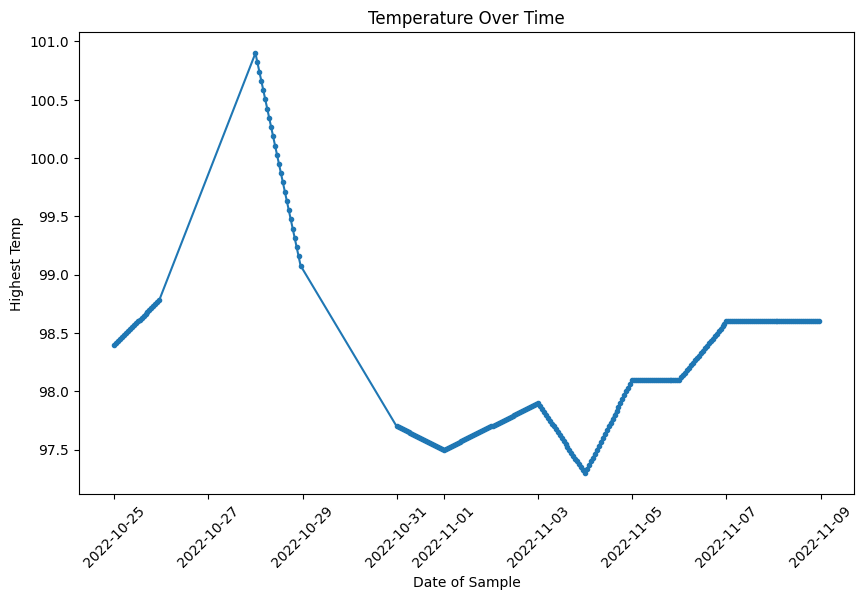

In [80]:
# Plot an example line chart

df_cytokine_pt_7001 = df_cytokine[df_cytokine['PT_ID']=="7002"]
plt.figure(figsize=(10, 6))
plt.plot(df_cytokine_pt_7001['Date of Sample'], df_cytokine_pt_7001["Highest Temp"],marker='.')
plt.xlabel("Date of Sample")
plt.ylabel("Highest Temp")
plt.title('Temperature Over Time')
plt.xticks(rotation=45)

plt.show()

In [81]:
df_cytokine_pt_7001['Date of Sample']

192   2022-10-25 00:00:00
193   2022-10-25 01:00:00
194   2022-10-25 02:00:00
195   2022-10-25 03:00:00
196   2022-10-25 04:00:00
              ...        
451   2022-11-08 19:00:00
452   2022-11-08 20:00:00
453   2022-11-08 21:00:00
454   2022-11-08 22:00:00
455   2022-11-08 23:00:00
Name: Date of Sample, Length: 264, dtype: datetime64[ns]

In [82]:
df_cytokine_pt_7001["Highest Temp"]

192    98.400000
193    98.416667
194    98.433333
195    98.450000
196    98.466667
         ...    
451    98.600000
452    98.600000
453    98.600000
454    98.600000
455    98.600000
Name: Highest Temp, Length: 264, dtype: float64

In [83]:
ID_match = pd.read_csv("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/ID_match")
ID_match

,CH_ID\tOlink_ID
0,1e1acd61-e506-4d15-b442-b84b0236d2be\tWEAR_7001
1,9e9e94c7-01a6-4840-8240-eaa4c13a95ca\tWEAR_7002
2,f90f3710-cbf9-4a8e-92c2-e6144b89bcff\tWEAR_7003
3,46a8959e-a3ef-49c4-99b4-6abd2341bed8\tWEAR_7004
4,2e5a988f-4e78-4648-ba15-60c43e33f72e\tWEAR_7005
5,7af1b94f-d193-4220-9437-d84a329a7e88\tWEAR_7006
6,65038550-1e25-4fd5-934a-7574c55ea662\tWEAR_7007
7,4f191869-d131-44f1-b6db-3d7dbfc77abd\tWEAR_7008
8,398a8fc9-e1ef-4dfd-8b72-7a93b4fe777c\tWEAR_7009
9,38a0fa6b-acf9-4204-a4a4-ea06da443987\tWEAR_7010


In [84]:
ID_match[["CH_ID", "Olink_ID"]] = ID_match["CH_ID\tOlink_ID"].str.split("\t", expand = True)
ID_match['Olink_ID'] = ID_match["Olink_ID"].str.extract(r"(\d+)$")
ID_match = ID_match.drop(columns=["CH_ID\tOlink_ID"])
ID_match

,CH_ID,Olink_ID
0,1e1acd61-e506-4d15-b442-b84b0236d2be,7001
1,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,7002
2,f90f3710-cbf9-4a8e-92c2-e6144b89bcff,7003
3,46a8959e-a3ef-49c4-99b4-6abd2341bed8,7004
4,2e5a988f-4e78-4648-ba15-60c43e33f72e,7005
5,7af1b94f-d193-4220-9437-d84a329a7e88,7006
6,65038550-1e25-4fd5-934a-7574c55ea662,7007
7,4f191869-d131-44f1-b6db-3d7dbfc77abd,7008
8,398a8fc9-e1ef-4dfd-8b72-7a93b4fe777c,7009
9,38a0fa6b-acf9-4204-a4a4-ea06da443987,7010


In [85]:
Nurse_data = pd.read_excel("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/CH_ID_MRN-Key_MM-clinical-annotated_2.2.23_DE_ID 2_updated.xlsx")
Nurse_data = pd.merge(Nurse_data, ID_match, left_on="patient id", right_on="CH_ID",how="left")
Nurse_data

,patient id,training_data,Enrolled,CAR-T infusion date,CAR-T product,First CRS timestamp (by RN),CRS marker at 1st timesamp,Subsequent CRS timestamps (by RN) and markrs,CRS Grade (max),CRS intervention,ICANS Grade,Standardized CAR-T product,Standardized First CRS timestamp (by RN),Temperature,SpO2,BP,HR,CH_ID,Olink_ID
0,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,1.0,2022-10-25,2022-10-25,Abecma,10/26/22 at 13:00,"Temp 100F, SpO2 WNL, BP WNL","10/28/22 at 15:22 (100.9F), 10/29/22 at 00:22 ...",1,"IVF, Tocilizumab x 1 on (10/29/22)",0,Abecma,2022-10-26 13:00:00,100F,WNL,WNL,NaN,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,7002
1,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,1.0,2022-10-25,2022-10-25,Abecma,10/26/22 at 13:00,"Temp 100F, SpO2 WNL, BP WNL","10/28/22 at 15:22 (100.9F), 10/29/22 at 00:22 ...",1,"IVF, Tocilizumab x 1 on (10/29/22)",0,Abecma,2022-10-26 13:00:00,100F,WNL,WNL,NaN,9e9e94c7-01a6-4840-8240-eaa4c13a95ca,7002
2,7af1b94f-d193-4220-9437-d84a329a7e88,1.0,2022-12-14,2022-12-14,Abecma,NaN,NaN,NaN,0,NaN,0,Abecma,NaN,NaN,NaN,NaN,NaN,7af1b94f-d193-4220-9437-d84a329a7e88,7006
3,7af1b94f-d193-4220-9437-d84a329a7e88,1.0,2022-12-14,2022-12-14,Abecma,NaN,NaN,NaN,0,NaN,0,Abecma,NaN,NaN,NaN,NaN,NaN,7af1b94f-d193-4220-9437-d84a329a7e88,7006
4,65038550-1e25-4fd5-934a-7574c55ea662,1.0,2023-01-06,2023-01-06,Carvykti,1/14/23 at 23:00,"Temp 101.3F, SpO2 WNL, BP WNL",1/15/2023 at 3:42:00 PM (101F),1,Tocilizumab x 1 on 1/14/23,0,Carvykti,2023-01-14 23:00:00,101.3F,WNL,WNL,NaN,65038550-1e25-4fd5-934a-7574c55ea662,7007
5,398a8fc9-e1ef-4dfd-8b72-7a93b4fe777c,1.0,2023-01-24,2023-01-24,Abecma,1/25/23 at 04:20,"Temp 100.6F, SpO2 WNL, BP WNL","1/25/23 07:30 (100.6F), 1/25/23 11:18 (101.6F)...",3,"Tocilizumab x 2 on 1/25/23 and 1/30/23, Anakin...",1,Abecma,2023-01-25 04:20:00,100.6F,WNL,WNL,NaN,398a8fc9-e1ef-4dfd-8b72-7a93b4fe777c,7009
6,4f191869-d131-44f1-b6db-3d7dbfc77abd,1.0,2023-01-23,2023-01-23,Abecma OOS - study by - product showing that i...,1/23/23 at 23:41,"Temp 100.6F, SpO2 WNL, BP WNL",1/24/23 at 07:57,1,Tocilizumab x 1 on 1/24/23,0,Abecma OOS,2023-01-23 23:41:00,100.6F,WNL,WNL,NaN,4f191869-d131-44f1-b6db-3d7dbfc77abd,7008
7,1e1acd61-e506-4d15-b442-b84b0236d2be,1.0,2022-10-20,2022-10-21,Abecma,1/21/22 at 23:30,"Temp 100.9F, SpO2 WNL, BP WNL",10/22/22 at 04:45,1,Tocilizumab x 1 on 1/22/24,0,Abecma,2022-01-21 23:30:00,100.9F,WNL,WNL,NaN,1e1acd61-e506-4d15-b442-b84b0236d2be,7001
8,46a8959e-a3ef-49c4-99b4-6abd2341bed8,1.0,2022-12-05,2022-12-05,Carvykti,NaN,NaN,NaN,0,NaN,0,Carvykti,NaN,NaN,NaN,NaN,NaN,46a8959e-a3ef-49c4-99b4-6abd2341bed8,7004
9,f90f3710-cbf9-4a8e-92c2-e6144b89bcff,1.0,2022-11-09,2022-11-09,CC-95266 GPRC5D CAR-T - BMS,11/11/2022 at 00:00,"Temp 100.6F, SpO2 WNL, BP WNL",11/11/22 15:35 (102.5F),1,Tocilizumab x 1 on 11/11/22,0,CC-95266 GPRC5D CAR-T - BMS,11/11/2022 at 00:00,100.6F,WNL,WNL,NaN,f90f3710-cbf9-4a8e-92c2-e6144b89bcff,7003


In [86]:
df_cytokine["Date of CAR-T infusion"].unique()

array(['10/21/22', '2022-10-25 00:00:00', '2022-11-09 00:00:00',
       '2022-12-05 00:00:00', '2022-12-07 00:00:00',
       '2022-12-14 00:00:00', '2023-01-06 00:00:00',
       '2023-01-23 00:00:00', '2023-01-24 00:00:00',
       '2023-01-31 00:00:00', '2023-02-07 00:00:00',
       '2023-02-09 00:00:00', '2023-03-13 00:00:00',
       '2023-04-04 00:00:00', '2023-04-18 00:00:00', '2023-04-27',
       '2023-05-23', '2023-06-07', '2023-06-08', '2023-07-05',
       '2023-07-13', '2023-07-21', '2023-08-08', '2023-09-08',
       '2023-09-20', '2023-09-28', '2023-10-11'], dtype=object)

In [87]:
df_plate01 = pd.read_excel("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/SAPA18_IO_Plate01_12022022_NPX_annotated_4.2023_LEWIS.xlsx", sheet_name = 1)
df_plate01 = df_plate01.dropna(subset = ['Date of CAR-T infusion'])
df_plate01

,Assay,Study ID,Visit/Sample,Date of collection,Date of CAR-T infusion,Days pre/post CAR-T,Timepoint,CAR-T product,CRS,CRS Grade,...,TNF,KLRD1,GZMB,CD83,IL12,CSF-1,Plate ID,QC Warning,QC Deviation from median,QC Deviation from median.1
0,BB2121_1191002_V1,BB2121_1191002,V1,11/9/19,1/14/20,-66.0,Pretherapy,BMS/KarMMa3,YES,2.0,...,4.21848,6.5878,3.28685,2.5997,6.19137,10.20109,SAPA18_IO_Plate01_12022022,Pass,-0.053563,0.027695
1,BB2121_1191002_V2,BB2121_1191002,V2,12/2/19,1/14/20,-43.0,Pretherapy,BMS/KarMMa4,YES,2.0,...,4.15183,6.27339,2.67159,2.48471,6.13242,10.08881,SAPA18_IO_Plate01_12022022,Pass,0.040633,0.147509
2,BB2121_1191002_V3,BB2121_1191002,V3,1/6/20,1/14/20,-8.0,Screening,BMS/KarMMa5,YES,2.0,...,4.41314,6.33125,3.07735,2.61878,6.7591,10.10784,SAPA18_IO_Plate01_12022022,Pass,0.014813,0.084704
3,BB2121_1191002_V4,BB2121_1191002,V4,1/14/20,1/14/20,0.0,DOI,BMS/KarMMa6,YES,2.0,...,3.74617,3.36125,1.46196,2.02498,5.39548,9.68096,SAPA18_IO_Plate01_12022022,Pass,-0.019356,0.002576
4,BB2121_1191002_V5,BB2121_1191002,V5,1/15/20,1/14/20,1.0,1,BMS/KarMMa7,YES,2.0,...,5.0206,4.74603,5.85778,2.41784,7.42475,10.09607,SAPA18_IO_Plate01_12022022,Pass,-0.007493,-0.028897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,SJA_JNJ_2034_CRS4,SJA_JNJ_2034,CRS4,11/14/19,11/5/19,9.0,9,JNJ,YES,3.0,...,6.26436,6.72625,7.75373,4.11458,6.44152,10.80037,SAPA18_IO_Plate01_12022022,Pass,0.129655,0.075843
81,SJA_JNJ_2034_V12,SJA_JNJ_2034,V12,11/15/19,11/5/19,10.0,10,JNJ,YES,3.0,...,5.26695,6.62012,7.88141,3.93848,5.25676,10.71171,SAPA18_IO_Plate01_12022022,Pass,-0.058216,0.037537
82,SJA_JNJ_2034_V13,SJA_JNJ_2034,V13,11/16/19,11/5/19,11.0,11,JNJ,YES,3.0,...,5.07013,6.60032,8.14364,4.04355,4.52708,10.7585,SAPA18_IO_Plate01_12022022,Pass,-0.044516,-0.040448
83,SJA_JNJ_2034_V14,SJA_JNJ_2034,V14,11/17/19,11/5/19,12.0,12,JNJ,YES,3.0,...,6.41631,6.01279,8.68755,3.60619,7.86729,10.89215,SAPA18_IO_Plate01_12022022,Pass,-0.012272,-0.002277


In [88]:
df_plate02 = pd.read_excel("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/SAPA18_IO_Plate02_12092022_NPX_annotated_4.2023_LEWIS.xlsx", sheet_name = 1)
df_plate02 = df_plate02.dropna(subset = ['Date of CAR-T infusion'])
df_plate02["Days Post CAR-T"] = df_plate02['Days pre/post CAR-T']
df_plate02["STUDY ID"] = df_plate02["Study ID"]
df_plate02["CRS GRADE"] = df_plate02["CRS Grade"] 
df_plate02

,Assay,Study ID,Visit/Sample,Date of collection,Date of CAR-T infusion,Days pre/post CAR-T,Timepoint,CAR-T product,CRS,CRS Grade,...,CD83,IL12,CSF-1,Plate ID,QC Warning,QC Deviation from median,QC Deviation from median.1,Days Post CAR-T,STUDY ID,CRS GRADE
0,ADRO02_COOS_002_V1,ADRO02_COOS_002,V1,6/7/22,6/15/22,-8.0,Pre LD,JNJ Carvykti OOS,YES,1.0,...,2.64549,6.69017,9.87804,SAPA18_IO_Plate02_12092022,Pass,-0.011623,0.003342,-8.0,ADRO02_COOS_002,1.0
1,ADRO02_COOS_002_V2,ADRO02_COOS_002,V2,6/15/22,6/15/22,0.0,DOI,JNJ Carvykti OOS,YES,1.0,...,2.43981,5.74906,9.72319,SAPA18_IO_Plate02_12092022,Pass,-0.174773,-0.073699,0.0,ADRO02_COOS_002,1.0
2,ADRO02_COOS_002_V3,ADRO02_COOS_002,V3,2022-06-16 00:00:00,2022-06-15 00:00:00,1.0,1,JNJ Carvykti OOS,YES,1.0,...,2.09291,6.1562,10.43668,SAPA18_IO_Plate03_12212022,Pass,0.202847,0.183292,1.0,ADRO02_COOS_002,1.0
3,ADRO02_COOS_002_V5,ADRO02_COOS_002,V5,6/21/22,6/15/22,6.0,6,JNJ Carvykti OOS,YES,1.0,...,2.87586,7.52555,10.63163,SAPA18_IO_Plate02_12092022,Pass,0.079474,0.070211,6.0,ADRO02_COOS_002,1.0
4,ADRO02_COOS_002_V6,ADRO02_COOS_002,V6,6/22/22,6/15/22,7.0,7,JNJ Carvykti OOS,YES,1.0,...,2.86055,7.79476,10.63882,SAPA18_IO_Plate02_12092022,Pass,-0.001372,-0.012080,7.0,ADRO02_COOS_002,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,SJA_402_1007_V5,SJA_402_1007,V5,8/31/20,8/24/20,7.0,7,BMS/bb2121,YES,1.0,...,2.81552,6.59403,10.05078,SAPA18_IO_Plate02_12092022,Pass,0.093213,0.080585,7.0,SJA_402_1007,1.0
83,SJA_402_1007_V6,SJA_402_1007,V6,9/8/20,8/24/20,15.0,15,BMS/bb2121,YES,1.0,...,3.21474,6.78341,10.27231,SAPA18_IO_Plate02_12092022,Pass,0.105396,0.008533,15.0,SJA_402_1007,1.0
84,SJA_402_1007_V7,SJA_402_1007,V7,9/14/20,8/24/20,21.0,21,BMS/bb2121,YES,1.0,...,3.18521,6.93436,10.38907,SAPA18_IO_Plate02_12092022,Pass,0.046592,0.069417,21.0,SJA_402_1007,1.0
85,SJA_402_1007_V8,SJA_402_1007,V8,9/22/20,8/24/20,29.0,29,BMS/bb2121,YES,1.0,...,3.12326,6.89062,10.18627,SAPA18_IO_Plate02_12092022,Pass,-0.010442,-0.014938,29.0,SJA_402_1007,1.0


In [89]:
df_plate03 = pd.read_excel("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/SAPA18_IO_Plate03_12212022_NPX_LEWIS.xlsx", sheet_name = 1)
df_plate03 = df_plate03.dropna(subset = ['Date of CAR-T Infusion'])
df_plate03

,Assay,STUDY ID,VISIT,Date of collection,Date of CAR-T Infusion,Days Post CAR-T,CRS,CRS GRADE,TIMEPOINT,BEST RESPONSE,...,TNF,KLRD1,GZMB,CD83,IL12,CSF-1,Plate ID,QC Warning,QC Deviation from median,QC Deviation from median.1
0,BB2121_1191004_V1,BB2121_1191004,V1,2020-01-14,3/3/2020,-49.0,NO,0.0,SCREENING,PD,...,3.16063,4.7354,1.27157,2.07254,6.5275,9.57145,SAPA18_IO_Plate03_12212022,Pass,-0.066561,-0.060011
1,BB2121_1191004_V2,BB2121_1191004,V2,2020-01-22,3/3/2020,-41.0,NO,0.0,SCREENING_PT2,PD,...,3.01449,4.63965,1.29177,1.92186,6.54177,9.55294,SAPA18_IO_Plate03_12212022,Pass,-0.087225,-0.179635
2,BB2121_1191004_V3,BB2121_1191004,V3,2020-02-25,3/3/2020,-7.0,NO,0.0,POST BRIDGING,PD,...,2.85605,4.27866,1.61396,1.69386,5.57425,9.50333,SAPA18_IO_Plate03_12212022,Pass,0.034732,-0.004954
3,BB2121_1191004_V4,BB2121_1191004,V4,2020-03-03,3/3/2020,0.0,NO,0.0,DOI,PD,...,2.57052,2.01645,0.00082,1.43904,4.65213,9.59303,SAPA18_IO_Plate03_12212022,Pass,-0.053735,-0.000598
4,BB2121_1191004_V5,BB2121_1191004,V5,2020-03-04,3/3/2020,1.0,YES,1.0,1,PD,...,5.21417,2.28812,3.64451,2.03285,7.61537,10.79376,SAPA18_IO_Plate03_12212022,Pass,-0.092057,0.065563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,BB2121_1541004_V16,BB2121_1541004,V16,2020-02-04,1/22/20,13.0,NO,0.0,13,PR,...,3.4456,5.43936,2.10685,1.80117,6.31374,9.3476,SAPA18_IO_Plate03_12212022,Pass,0.068213,0.045117
80,BB2121_1541004_V17,BB2121_1541004,V17,2020-02-05,1/22/20,14.0,NO,0.0,14,PR,...,3.6839,6.06824,3.09509,2.32603,7.05179,9.85684,SAPA18_IO_Plate03_12212022,Pass,0.114351,0.062558
81,BB2121_1541004_V18,BB2121_1541004,V18,2020-01-19,1/22/20,-3.0,NO,0.0,LYMPHODEPLETION,PR,...,3.868,5.58333,2.32507,2.29253,7.18028,9.91529,SAPA18_IO_Plate03_12212022,Pass,0.178551,0.107452
82,ADRO02_COOS_002_V3,ADRO02_COOS_002,V3,2022-06-16,2022-06-15 00:00:00,1.0,NO,0.0,1,PD,...,3.32139,2.54983,2.69451,2.09291,6.1562,10.43668,SAPA18_IO_Plate03_12212022,Pass,0.202847,0.183292


In [90]:
df_plate04 = pd.read_excel("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/SAPA18_IO_Plate04_12272022_NPX_LEWIS.xlsx", sheet_name = 1)
df_plate04 = df_plate04.dropna(subset = ['Date of CAR-T Infusion'])
df_plate04

,Assay,STUDY ID,VISIT,Date of collection,Date of CAR-T Infusion,Days Post CAR-T,CRS,CRS GRADE,TIMEPOINT,BEST RESPONSE,...,TNF,KLRD1,GZMB,CD83,IL12,CSF-1,Plate ID,QC Warning,QC Deviation from median,QC Deviation from median.1
0,JNJ-CART-003_V2,JNJ-CART-003,V2,2019-01-02,1/2/2019,0.0,NO,0.0,DOI,sCR,...,6.11872,5.41604,5.59648,3.48944,7.22322,11.06283,SAPA18_IO_Plate04_12272022,Pass,0.088087,0.061662
1,SJA-CART-003_V3,SJA-CART-003,V3,2019-01-03,1/2/2019,1.0,NO,0.0,1,sCR,...,6.33104,5.44185,4.31791,3.36951,8.07458,11.23507,SAPA18_IO_Plate04_12272022,Pass,0.062016,0.154009
2,JNJ-CART-003_V4,JNJ-CART-003,V4,2019-01-04,1/2/2019,2.0,NO,0.0,2,sCR,...,6.32838,5.20390,4.86541,3.47289,8.37809,11.12480,SAPA18_IO_Plate04_12272022,Pass,0.140214,0.188823
3,JNJ-CART-003_V7,JNJ-CART-003,V7,2019-01-07,1/2/2019,5.0,NO,0.0,5,sCR,...,6.34709,5.60628,6.41888,3.35782,7.89582,11.00011,SAPA18_IO_Plate04_12272022,Pass,-0.019036,0.040712
4,JNJ-CART-003_V8,JNJ-CART-003,V8,2019-01-08,1/2/2019,6.0,NO,0.0,6,sCR,...,6.60845,5.25469,7.29723,3.50889,7.44411,10.94793,SAPA18_IO_Plate04_12272022,Pass,-0.030552,0.028088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,SJA_JNJ_2033_V12,SJA_JNJ_2033,V12,2019-11-15,11/5/2019,10.0,YES,1.0,10,SCR,...,4.43335,2.77969,1.79088,2.46688,6.01780,10.58774,SAPA18_IO_Plate04_12272022,Pass,0.050817,-0.107674
83,SJA_JNJ_2033_V13,SJA_JNJ_2033,V13,2019-11-18,11/5/2019,13.0,YES,1.0,13,SCR,...,4.47006,3.08682,2.93412,2.63456,6.45125,10.80110,SAPA18_IO_Plate04_12272022,Pass,0.000000,-0.097906
84,SJA_JNJ_2033_V14,SJA_JNJ_2033,V14,2019-11-18,11/5/2019,13.0,YES,1.0,13,SCR,...,5.28013,3.54537,3.99574,3.07258,6.99590,10.82074,SAPA18_IO_Plate04_12272022,Pass,0.103110,0.045026
85,SJA_JNJ_2033_V15,SJA_JNJ_2033,V15,2019-11-19,11/5/2019,14.0,NO,0.0,14,SCR,...,4.92782,3.51804,3.34722,2.77952,6.68531,10.52508,SAPA18_IO_Plate04_12272022,Pass,-0.072349,-0.133622


In [91]:
date_merged_0304 = pd.concat([df_plate03, df_plate04], axis=0)
date_merged_0102 = pd.concat([df_plate01, df_plate02], axis=0)

In [92]:
date_merged_0304["STUDY ID"].nunique()

17

In [93]:
date_merged_0102['STUDY ID'].nunique()

7

In [94]:
a = list(date_merged_0102['STUDY ID'].unique())

In [95]:
b = list(date_merged_0304['STUDY ID'].unique())

In [96]:
concat_list_study_id = a+b
concat_list_study_id[1:]

['ADRO02_COOS_002',
 'ADRO02_COOS_004',
 'BB2121_1191001',
 'BB2121_1541005',
 'BB2121_1541006',
 'SJA_402_1006',
 'SJA_402_1007',
 'BB2121_1191004',
 'BB2121_1191006',
 'BB2121_1191007',
 'BB2121_1541002',
 'BB2121_1541003',
 'BB2121_1541004',
 'ADRO02_COOS_002',
 'BB2121_1541006',
 'JNJ-CART-003',
 'SJA-CART-003',
 'SJA-JNJ-003',
 'SJA_JNJ_2009',
 'SJA_JNJ_2024',
 'SJA_JNJ_2025',
 'SJA_JNJ_2027',
 'SJA_JNJ_2030',
 'SJA_JNJ_2033']

In [97]:
list(date_merged_0102.columns)

['Assay',
 'Study ID',
 'Visit/Sample',
 'Date of collection',
 'Date of CAR-T infusion',
 'Days pre/post CAR-T',
 'Timepoint',
 'CAR-T product',
 'CRS',
 'CRS Grade',
 'Best response',
 'EOT',
 'PD',
 'Date of Death',
 'Date of last follow up',
 'PFS',
 'IL8',
 'TNFRSF9',
 'TIE2',
 'MCP-3',
 'CD40-L',
 'IL-1 alpha',
 'CD244',
 'EGF',
 'ANGPT1',
 'IL7',
 'PGF',
 'IL6',
 'ADGRG1',
 'MCP-1',
 'CRTAM',
 'CXCL11',
 'MCP-4',
 'TRAIL',
 'FGF2',
 'CXCL9',
 'CD8A',
 'CAIX',
 'MUC-16',
 'ADA',
 'CD4',
 'NOS3',
 'IL2',
 'Gal-9',
 'VEGFR-2',
 'CD40',
 'IL18',
 'GZMH',
 'KIR3DL1',
 'LAP TGF-beta-1',
 'CXCL1',
 'TNFSF14',
 'IL33',
 'TWEAK',
 'PDGF subunit B',
 'PDCD1',
 'FASLG',
 'CD28',
 'CCL19',
 'MCP-2',
 'CCL4',
 'IL15',
 'Gal-1',
 'PD-L1',
 'CD27',
 'CXCL5',
 'IL5',
 'HGF',
 'GZMA',
 'HO-1',
 'CX3CL1',
 'CXCL10',
 'CD70',
 'IL10',
 'TNFRSF12A',
 'CCL23',
 'CD5',
 'CCL3',
 'MMP7',
 'ARG1',
 'NCR1',
 'DCN',
 'TNFRSF21',
 'TNFRSF4',
 'MIC-A/B',
 'CCL17',
 'ANGPT2',
 'PTN',
 'CXCL12',
 'IFN-gamma'

In [98]:
df_03_04 = pd.concat([df_plate03, df_plate04], axis=0, ignore_index=True)
df_03_04["CRS_numeric"] = np.where(df_03_04['CRS']=="YES",1,0)
cols_to_convert = ['CRS_numeric','CRS GRADE','KIR3DL1', 'LAP TGF-beta-1','CXCL1', 'TNFSF14', 'IL33', 'TWEAK', 
 'PDGF subunit B', 'PDCD1', 'FASLG', 'CD28', 'CCL19', 'MCP-2', 
 'CCL4', 'IL15', 'Gal-1', 'PD-L1', 'CD27', 'CXCL5', 'IL5', 'HGF', 
 'GZMA', 'HO-1', 'CX3CL1', 'CXCL10', 'CD70', 'IL10', 'TNFRSF12A', 
 'CCL23', 'CD5', 'CCL3', 'MMP7', 'ARG1', 'NCR1', 'DCN', 'TNFRSF21', 
 'TNFRSF4', 'MIC-A/B', 'CCL17', 'ANGPT2', 'PTN', 'CXCL12', 
 'IFN-gamma', 'LAMP3', 'CASP-8', 'ICOSLG', 'MMP12', 'CXCL13', 
 'PD-L2', 'VEGFA', 'IL4', 'LAG3', 'IL12RB1', 'IL13', 'CCL20', 
 'TNF', 'KLRD1', 'GZMB', 'CD83', 'IL12', 'CSF-1'] 
df_03_04[cols_to_convert] = df_03_04[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [99]:
df_03_04['CRS']

0       NO
1       NO
2       NO
3       NO
4      YES
      ... 
166    YES
167    YES
168    YES
169     NO
170     NO
Name: CRS, Length: 171, dtype: object

In [100]:
df_03_04['CRS_numeric']

0      0
1      0
2      0
3      0
4      1
      ..
166    1
167    1
168    1
169    0
170    0
Name: CRS_numeric, Length: 171, dtype: int64

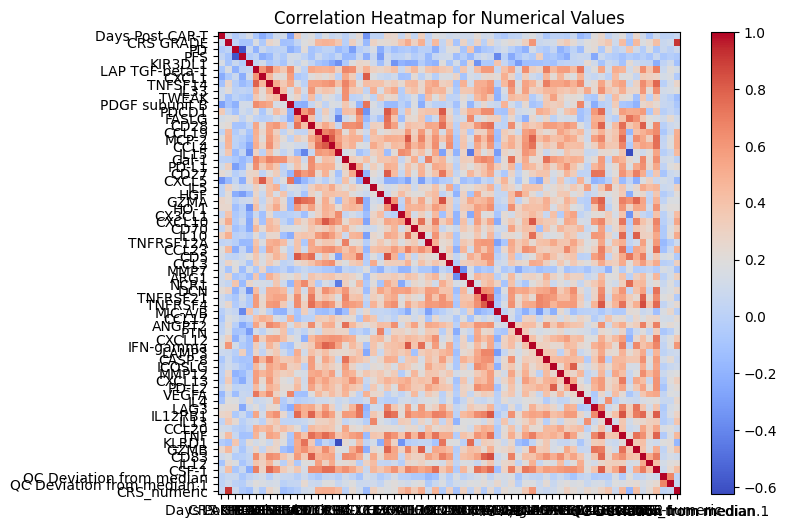

In [101]:
#draw a correlation heatmap
numerical_df = df_03_04.select_dtypes(include=[np.number])
corr_matrix = numerical_df.corr()

plt.figure(figsize=(8,6))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(numerical_df.columns)),numerical_df.columns)
plt.yticks(range(len(numerical_df.columns)), numerical_df.columns)
plt.title("Correlation Heatmap for Numerical Values")
plt.show()

In [102]:
corr_pairs = corr_matrix.unstack()
corr_pairs
sorted_corr = corr_pairs[corr_pairs != 1].sort_values(ascending=False).drop_duplicates()
sorted_corr

CRS_numeric  CRS GRADE    0.911284
TNFRSF4      CD83         0.850047
GZMA         CD5          0.840038
IL12RB1      TNF          0.833923
TNFRSF4      IL12RB1      0.818688
                            ...   
MIC-A/B      PFS         -0.392107
FASLG        IL15        -0.404037
IL15         NCR1        -0.446560
PFS          PD          -0.581583
KLRD1        IL15        -0.625575
Length: 2211, dtype: float64

In [103]:
corr_matrix['CRS_numeric'].sort_values(ascending=False).head(10)

CRS_numeric    1.000000
CRS GRADE      0.911284
IFN-gamma      0.599593
CXCL10         0.534341
IL10           0.515795
CCL4           0.508081
MCP-2          0.505294
CCL19          0.496554
CCL23          0.469346
TNF            0.451725
Name: CRS_numeric, dtype: float64

In [104]:
corr_matrix['CRS GRADE'].sort_values(ascending=False).head(10)

CRS GRADE      1.000000
CRS_numeric    0.911284
IFN-gamma      0.600521
CXCL10         0.517173
IL10           0.493559
MCP-2          0.479546
CCL4           0.467855
CCL19          0.460010
GZMB           0.452644
CCL23          0.446133
Name: CRS GRADE, dtype: float64

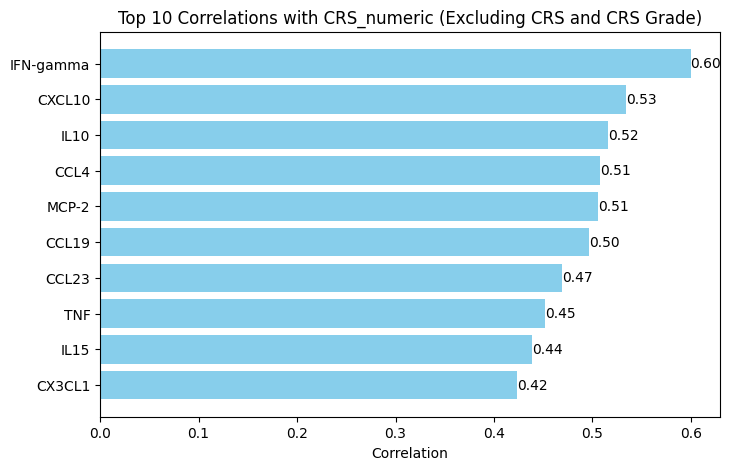

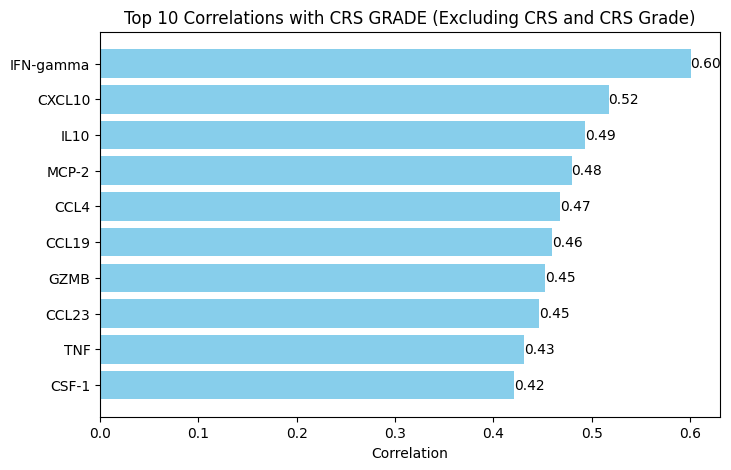

In [105]:
# Corrected code without syntax formatting errors
def plot_correlations(corr_matrix, target_column, top_n=10):
    # Extract the top correlations for the specified target column, excluding the first two ('self' and CRS grade)
    correlations = corr_matrix[target_column].sort_values(ascending=False).iloc[2:top_n + 2]
    
    # Create a bar plot
    plt.figure(figsize=(8, 5))
    bars = plt.barh(correlations.index, correlations.values, color='skyblue')
    plt.xlabel('Correlation')
    plt.title(f'Top {top_n} Correlations with {target_column} (Excluding CRS and CRS Grade)')
    plt.gca().invert_yaxis()  # To display the highest correlation on top

    # Annotate the bars with correlation values
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

    plt.show()

# Assuming corr_matrix is your DataFrame containing the correlation values
plot_correlations(corr_matrix, 'CRS_numeric', top_n=10)
plot_correlations(corr_matrix, 'CRS GRADE', top_n=10)



In [106]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_temperature_by_study_id(df, column_name):
    # Ensure the 'Date of collection' is in datetime format and sort the data by 'Date of collection'
    df['Date of collection'] = pd.to_datetime(df['Date of collection'])
    df = df.sort_values(by='Date of collection')
    
    # Group the data by 'STUDY ID'
    grouped = df.groupby('STUDY ID')

    # Iterate over each group (study ID)
    for study_id, group in grouped:
        # Find the baseline: the largest negative number in 'Days Post CAR-T'
        negative_days = group[group['Days Post CAR-T'] < 0]
        
        if not negative_days.empty:
            # If there are negative values, find the baseline
            baseline_row = negative_days.iloc[negative_days['Days Post CAR-T'].argmax()]
            baseline_value = baseline_row[column_name]
            baseline_date = baseline_row['Date of collection']
        else:
            # If there are no negative values, skip this group or choose a different baseline
            print(f"No negative 'Days Post CAR-T' values for Study ID: {study_id}. Skipping.")
            continue

        # Subtract the baseline value from the column values
        group['Adjusted Value'] = group[column_name] - baseline_value

        # Determine if the patient has CRS and its grade
        crs_status = group['CRS'].str.contains('YES').any()
        crs_grades = group[group['CRS'] == 'YES']['CRS GRADE'].unique()
        crs_info = f"CRS: {'Yes' if crs_status else 'No'}"
        if crs_status:
            crs_info += f", Grade: {', '.join(map(str, crs_grades))}"

        # Plotting the line chart
        plt.figure(figsize=(10, 6))
        plt.plot(group['Date of collection'], group['Adjusted Value'], marker='o', label=f'Study ID: {study_id}')
        plt.axvline(baseline_date, color='r', linestyle='--', label='Baseline Date')
        
        # Mark the baseline point on the chart
        plt.scatter(baseline_date, 0, color='red', zorder=5)
        plt.text(baseline_date, 0, ' Baseline', color='red', verticalalignment='bottom')
        
        # Label points where CRS is 1 (or 'YES')
        crs_points = group[group['CRS'] == 'YES']
        for idx, row in crs_points.iterrows():
            plt.scatter(row['Date of collection'], row['Adjusted Value'], color='blue', zorder=5)
            plt.text(row['Date of collection'], row['Adjusted Value'], ' CRS', color='blue', verticalalignment='bottom')

        # Set labels and title
        plt.xlabel('Date of collection')
        plt.ylabel(f'Adjusted {column_name}')
        plt.title(f'{column_name} Adjustment for Study ID: {study_id} ({crs_info})')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        # Show the plot
        plt.show()

# Assuming you have a DataFrame named 'df' loaded with the data and a column called 'IL12'
# plot_temperature_by_study_id(df, 'IL12')


No negative 'Days Post CAR-T' values for Study ID: JNJ-CART-003. Skipping.
No negative 'Days Post CAR-T' values for Study ID: SJA-CART-003. Skipping.
No negative 'Days Post CAR-T' values for Study ID: SJA-JNJ-003. Skipping.


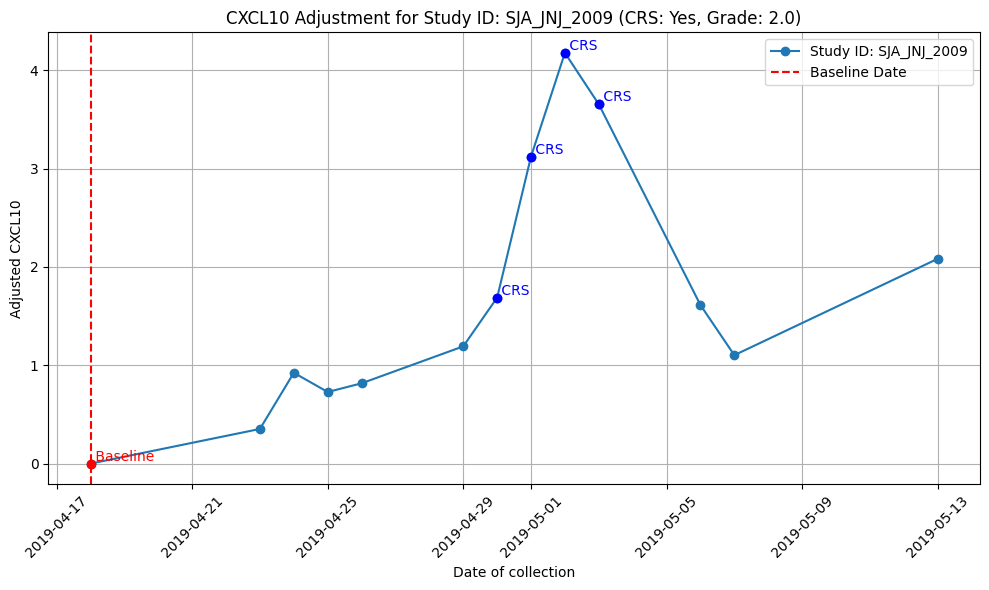

No negative 'Days Post CAR-T' values for Study ID: SJA_JNJ_2024. Skipping.


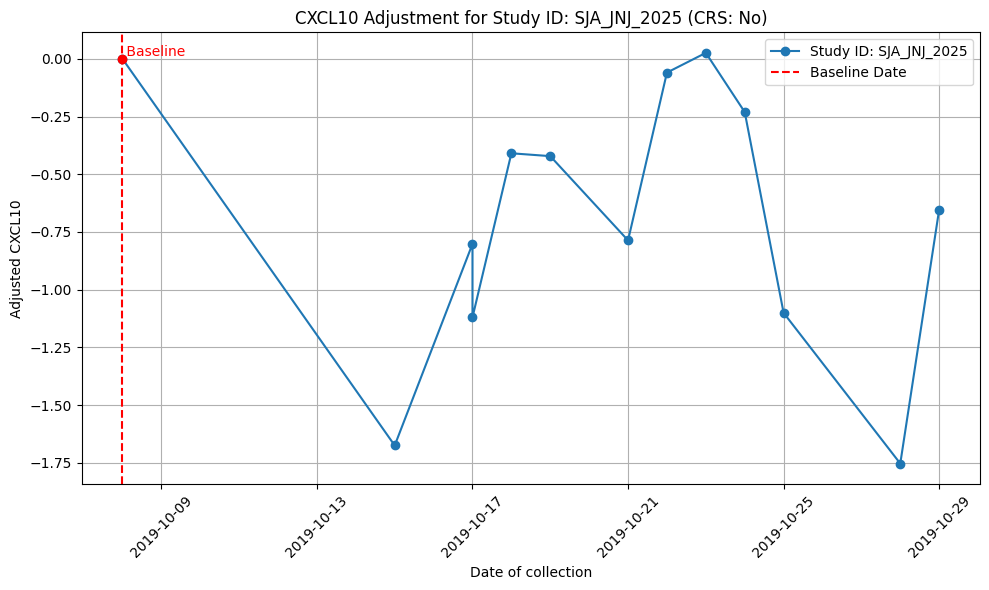

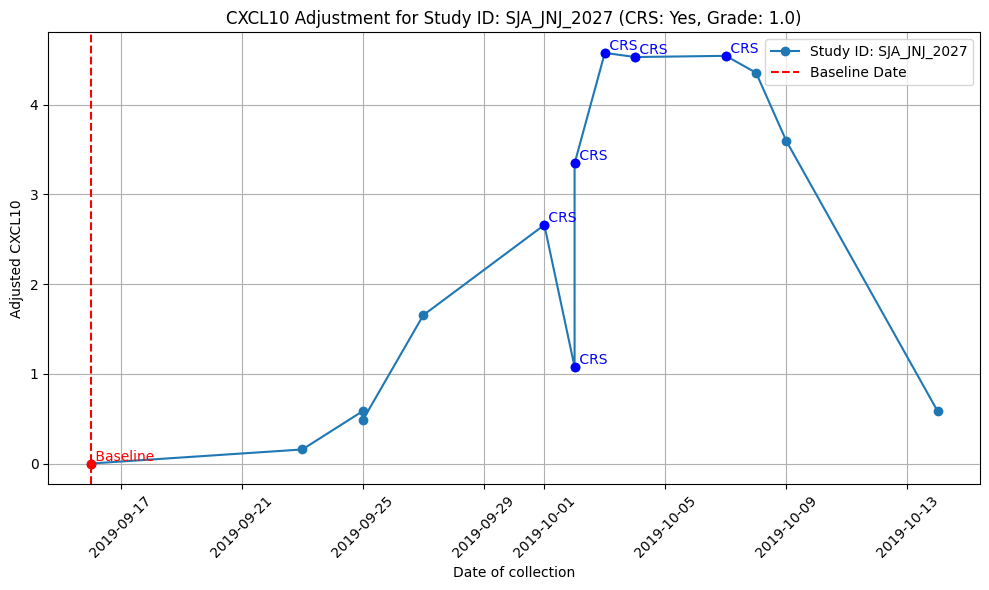

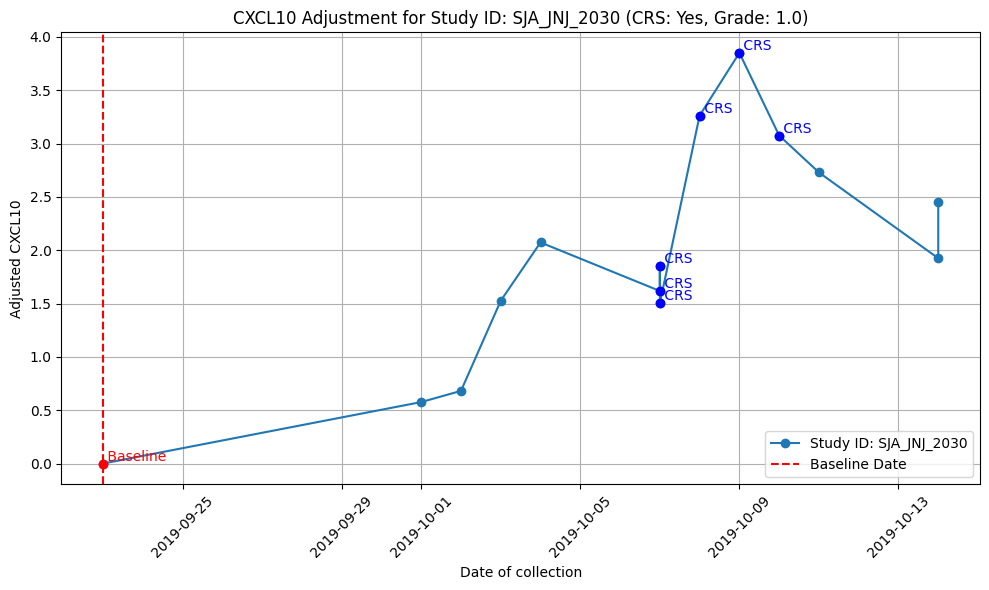

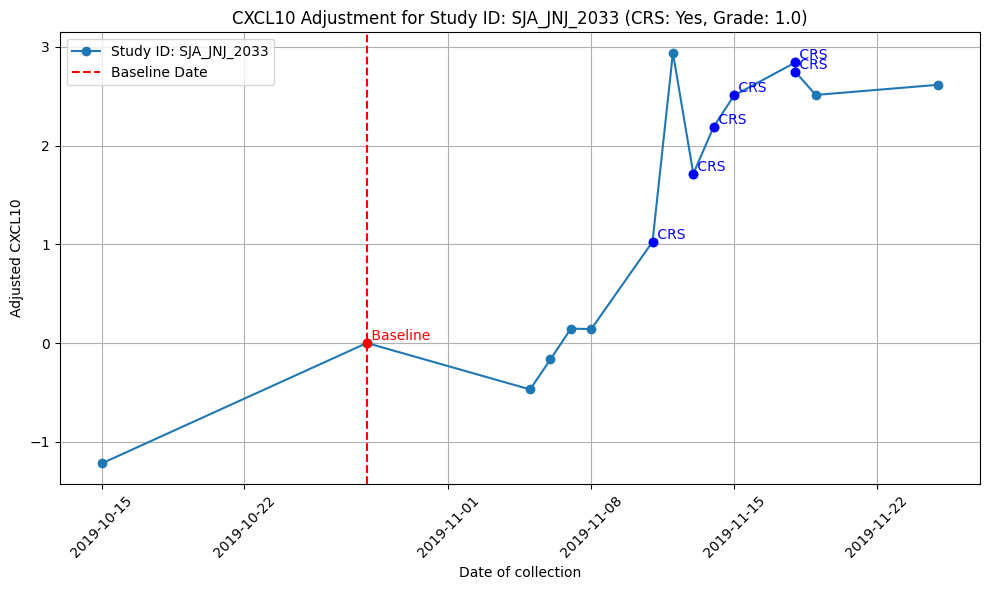

In [107]:
plot_temperature_by_study_id(df_plate04,"CXCL10")

No negative 'Days Post CAR-T' values for Study ID: ADRO02_COOS_002. Skipping.


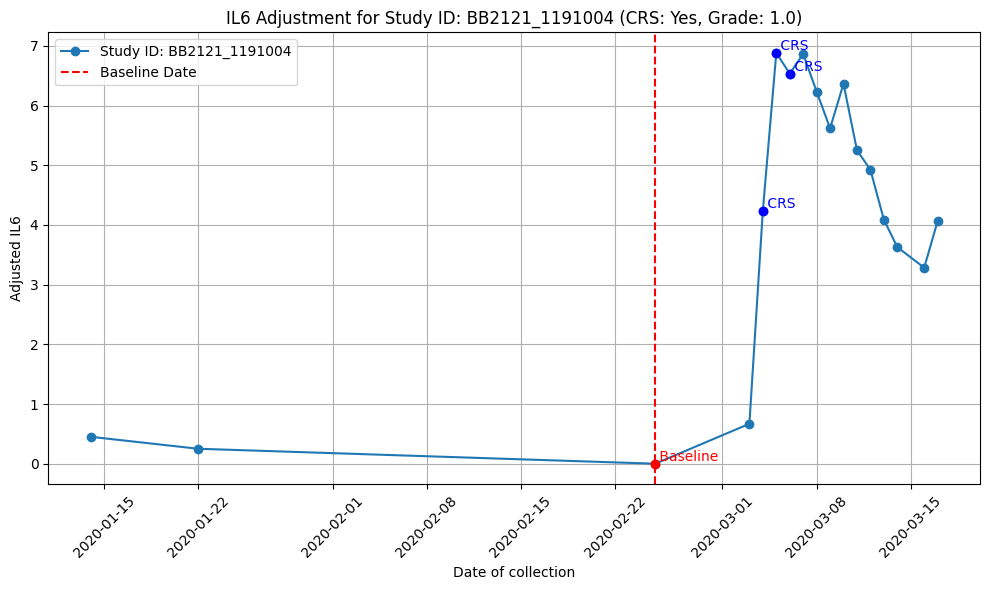

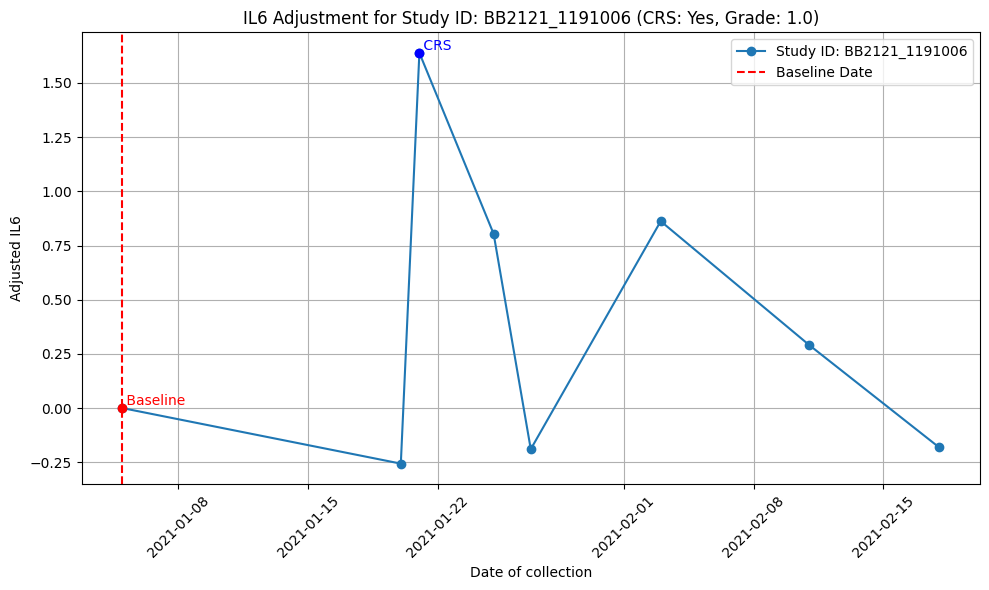

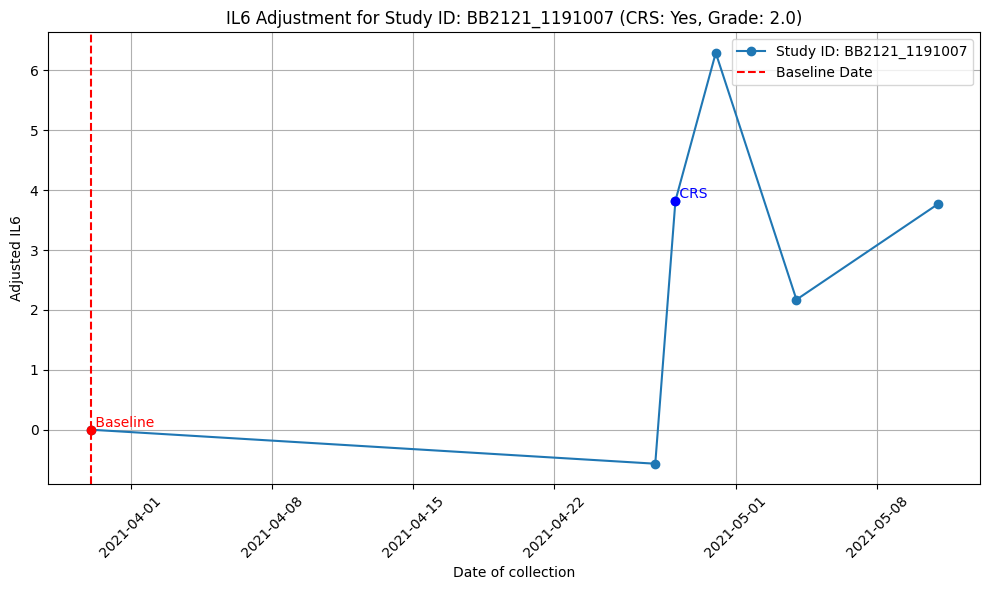

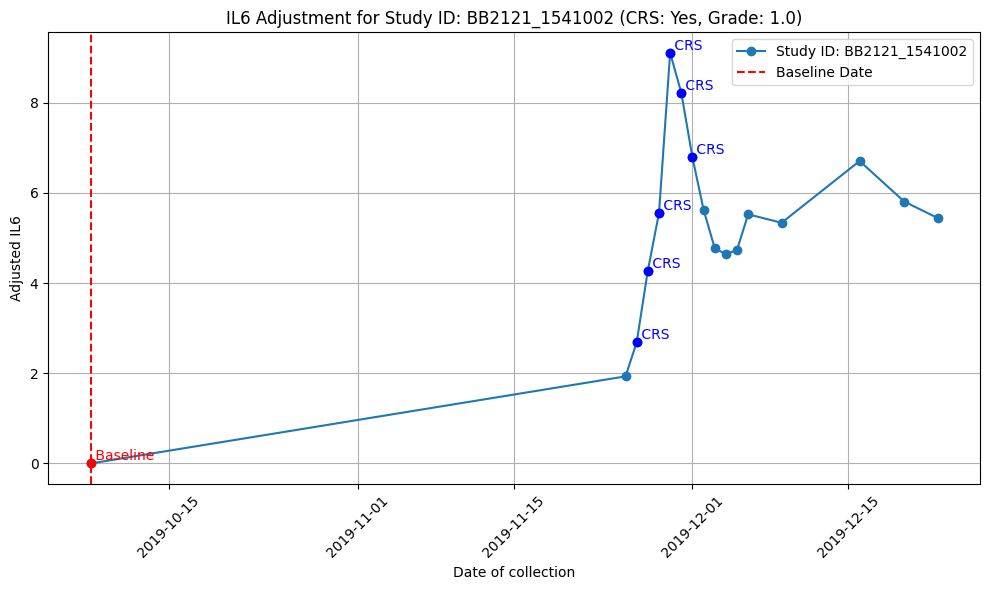

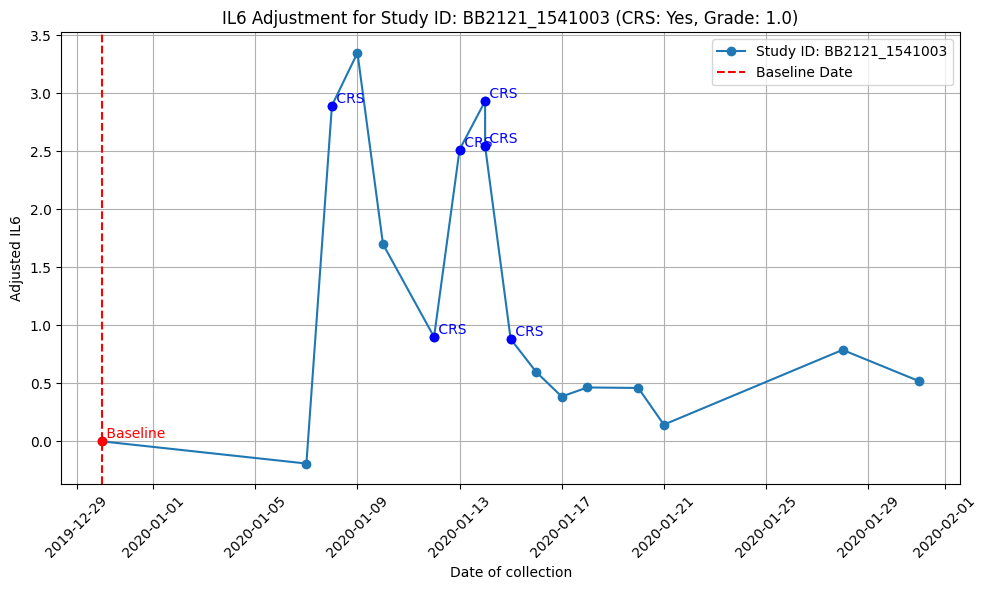

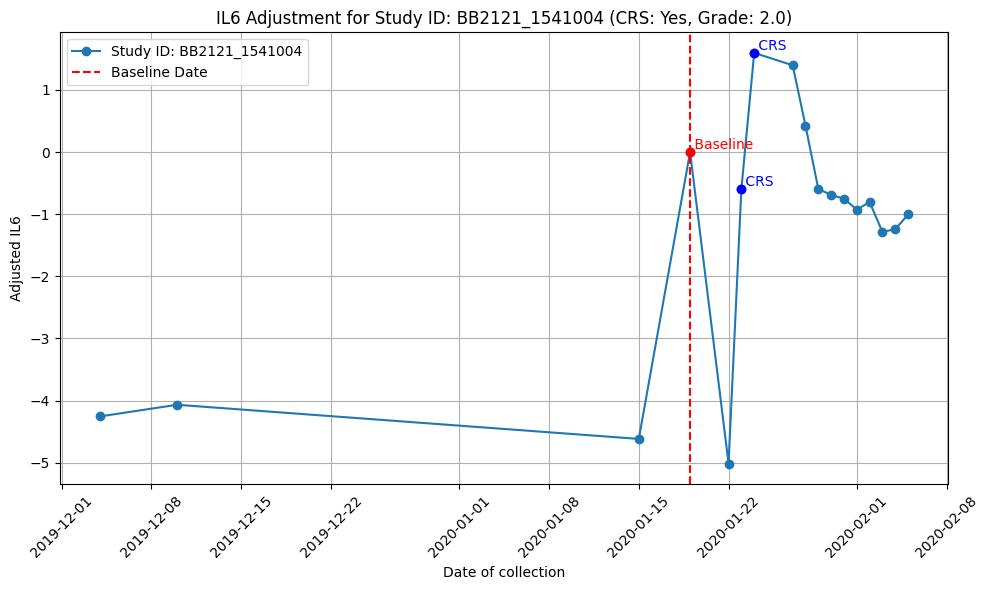

No negative 'Days Post CAR-T' values for Study ID: BB2121_1541006. Skipping.


In [108]:
plot_temperature_by_study_id(df_plate03,"IL6")

In [109]:
df_plate04[df_plate04["STUDY ID"]=="SJA_JNJ_2009"]["CXCL10"]

9     10.36590
10    10.71854
11    11.28973
12    11.09430
13    11.18261
14    11.55830
15    12.05342
16    13.48820
17    14.54242
18    14.01978
19    11.97833
20    11.46870
21    12.44839
Name: CXCL10, dtype: float64

In [110]:
( 14.54242-10.36590)/(11.55830-10.36590)

3.5026165716202637

In [111]:
df_03_04.isna().sum()

Assay                         0
STUDY ID                      0
VISIT                         0
Date of collection            0
Date of CAR-T Infusion        0
                             ..
Plate ID                      0
QC Warning                    0
QC Deviation from median      0
QC Deviation from median.1    0
CRS_numeric                   0
Length: 112, dtype: int64

In [112]:
df_cytokine = pd.read_csv("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/Cytokine_Data.csv")
df_cytokine['PT_ID'] = df_cytokine['PT_ID'].str.extract(r"(\d+)$")
df_cytokine['PT_ID']

0       7001
1       7001
2       7001
3       7001
4       7001
        ... 
8828    7029
8829    7029
8830    7029
8831    7029
8832    7029
Name: PT_ID, Length: 8833, dtype: object

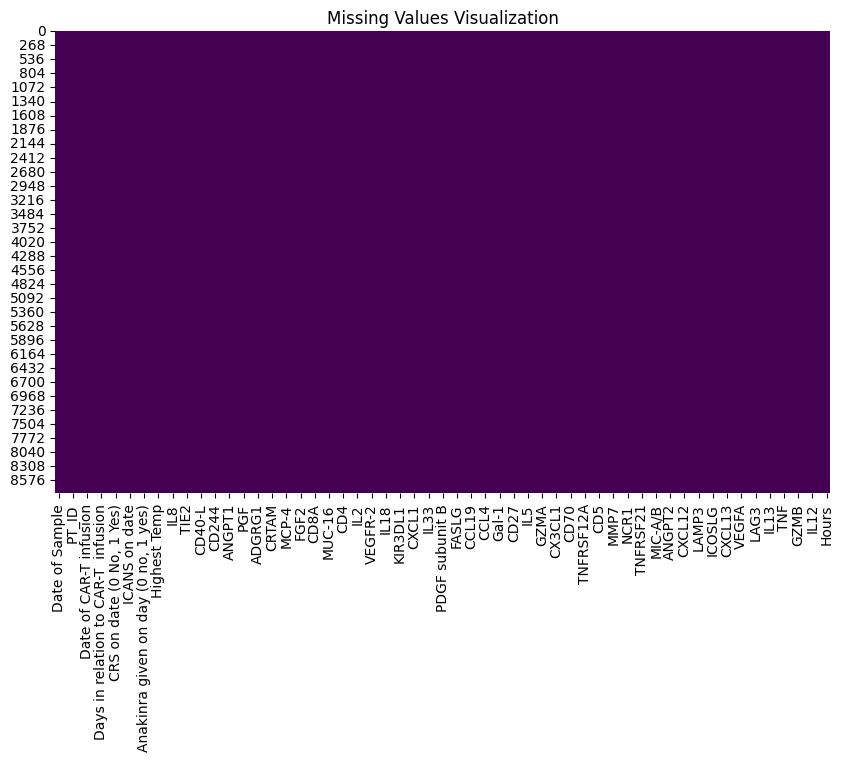

In [113]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_cytokine.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Visualization")
plt.show()

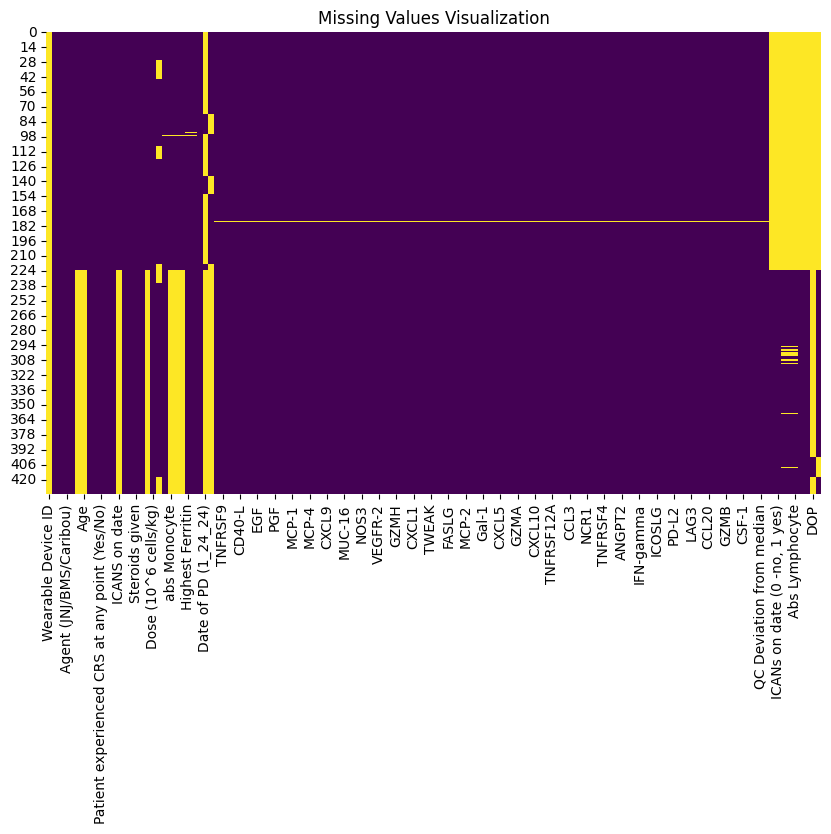

In [114]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Visualization")
plt.show()

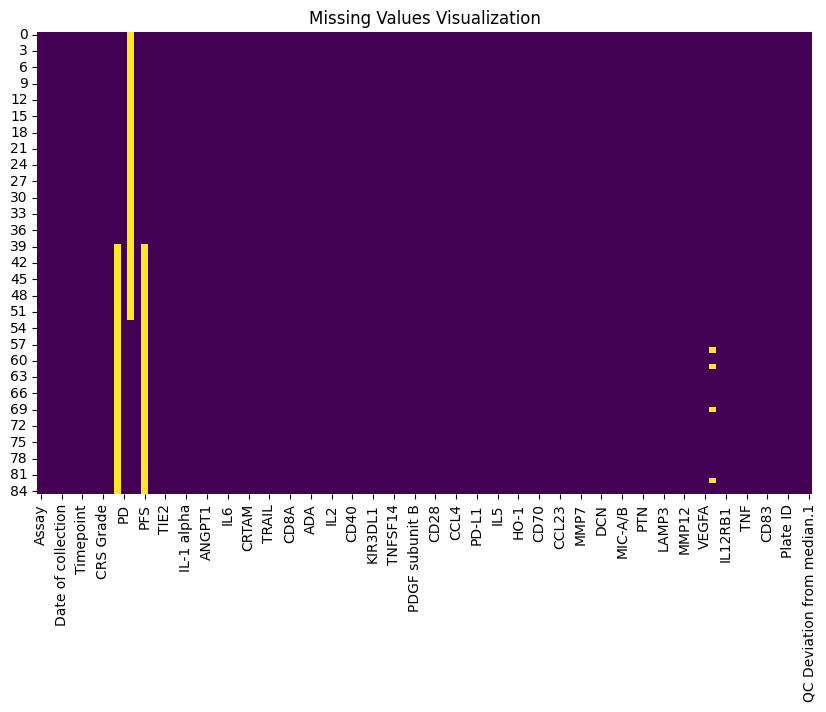

In [115]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_plate01.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Visualization")
plt.show()

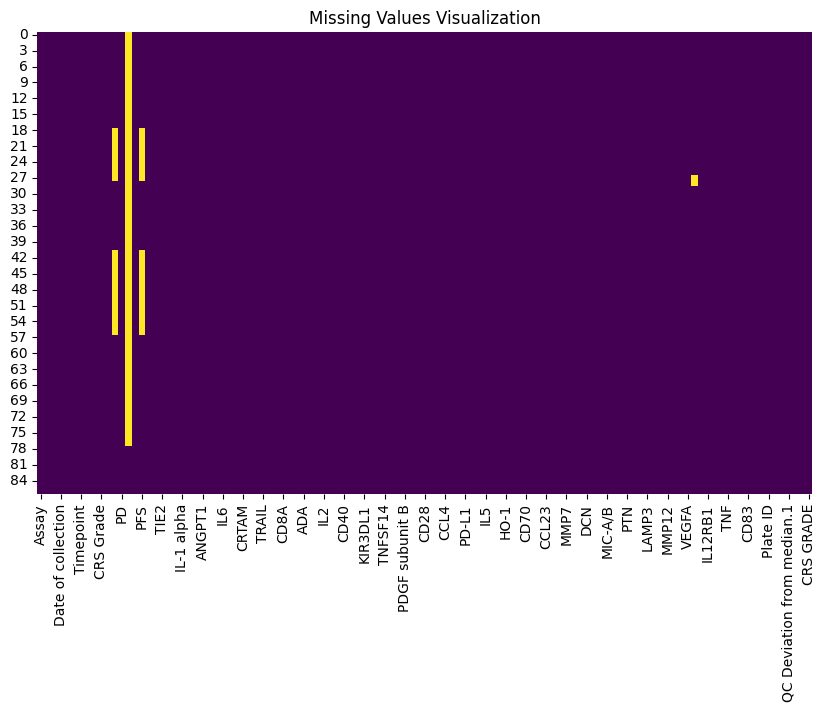

In [116]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_plate02.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Visualization")
plt.show()

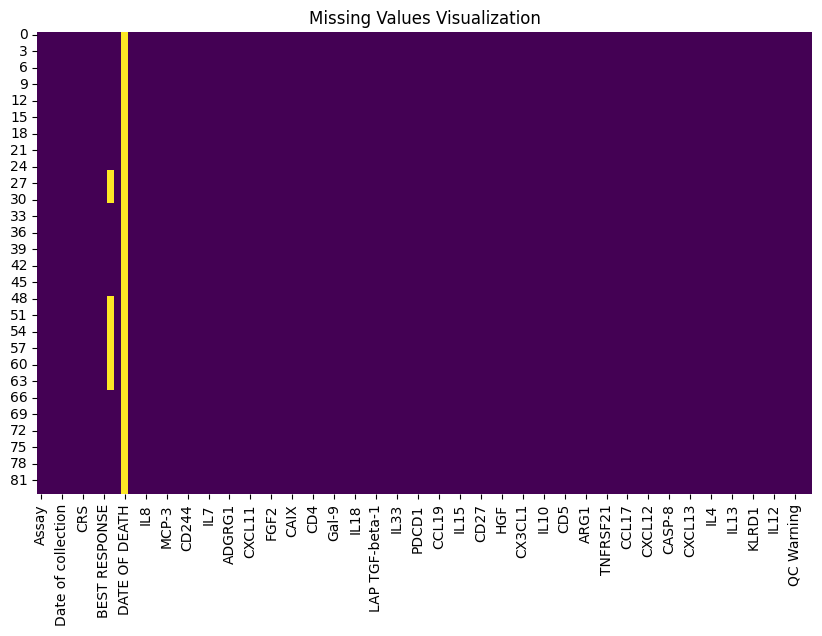

In [117]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_plate03.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Visualization")
plt.show()

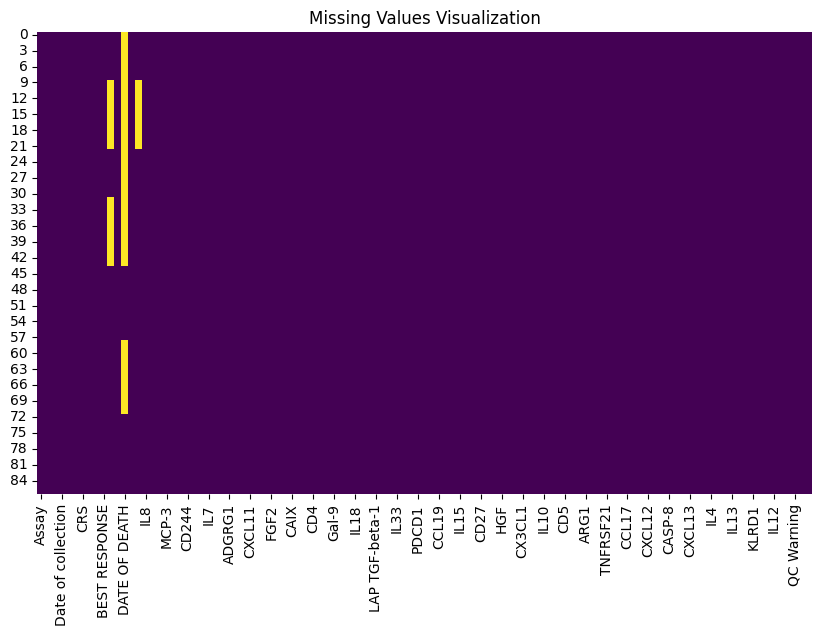

In [118]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_plate04.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Visualization")
plt.show()

In [119]:
import pandas as pd

df1 = df
df2 = df_plate01
df3 = df_plate02
df4 = df_plate03
df5 = df_plate04

df1["Identifier"] = df["PT_ID"]
df2["Identifier"] = df2["Study ID"]
df3["Identifier"] = df3["Study ID"]
df4["Identifier"] = df4["STUDY ID"]
df5["Identifier"] = df5["STUDY ID"]

df1["CRS"] = df["Patient experienced CRS at any point (Yes/No)"]

# Sample DataFrames: df1, df2, df3, df4, df5

# Step 1: Find common columns across all datasets
common_columns = set(df1.columns) & set(df2.columns) & set(df3.columns) & set(df4.columns) & set(df5.columns)

# Step 2: Convert the common columns back to a list for indexing
common_columns = list(common_columns)

# Step 3: Select only the common columns from each dataset
df1_common = df1[common_columns]
df2_common = df2[common_columns]
df3_common = df3[common_columns]
df4_common = df4[common_columns]
df5_common = df5[common_columns]

# Step 4: Concatenate the datasets along rows (axis=0)
concatenated_df = pd.concat([df1_common, df2_common, df3_common, df4_common, df5_common], axis=0)

# Step 5: (Optional) Reset index if you want a clean index after concatenation
concatenated_df.reset_index(drop=True, inplace=True)

# Step 6: Print or check the resulting DataFrame
print(concatenated_df)


        CXCL9      DCN     CAIX      IL5     LAG3      IL4 TNFRSF21     CD70  \
0     9.00336  2.80489  4.82153 -0.42626  5.45556  0.62395  8.97404  3.73004   
1     9.55551  3.13261  4.83533  1.00934  5.22607  1.30779  9.28134  4.16272   
2     9.81999  3.16429  4.71742  0.23807  5.08071  1.46107  9.15579  4.09067   
3    10.60925  3.13671  4.53055 -0.18134  5.38096  1.42481   8.8865  4.08733   
4    10.79508  3.19629   4.7847  0.34485  6.31011   1.7793  9.05394  4.57867   
..        ...      ...      ...      ...      ...      ...      ...      ...   
772   8.82492  5.07116  6.10651 -0.62325  4.55641 -0.73236  7.28323  4.67683   
773   9.52034  5.96654  5.45847  1.03214  5.37774 -0.32391  7.18663  5.25456   
774   9.54677  5.34941  5.88291  0.18208  5.27083 -0.67906  7.38809  5.10154   
775   9.41686  5.14865  5.78167 -0.30173  5.13306  -0.2826  7.25128  4.77706   
776   9.94138  5.13448  5.60432  0.60458  5.51322 -0.61983  7.40918  4.84723   

     TNFRSF9       HGF  ...    LAMP3   

In [130]:
concatenated_df.Identifier.unique()

array([7001.0, 7006.0, 7009.0, 7011.0, 7002.0, 7003.0, 7007.0, 7012.0,
       7004.0, 7008.0, 7014.0, 7005.0, 7010.0, 7015.0, 7013.0, 7016.0,
       7017.0, 7018.0, 7019.0, 7020.0, 7021.0, 7022.0, 7023.0, 7024.0,
       7025.0, 7026.0, 7027.0, 7028.0, 7029.0, 7030.0, 'BB2121_1191002',
       'SAPA16_001', 'SJA_JNJ_2008', 'SJA_JNJ_2029', 'SJA_JNJ_2032',
       'SJA_JNJ_2034', 'ADRO02_COOS_002', 'ADRO02_COOS_004',
       'BB2121_1191001', 'BB2121_1541005', 'BB2121_1541006',
       'SJA_402_1006', 'SJA_402_1007', 'BB2121_1191004', 'BB2121_1191006',
       'BB2121_1191007', 'BB2121_1541002', 'BB2121_1541003',
       'BB2121_1541004', 'JNJ-CART-003', 'SJA-CART-003', 'SJA-JNJ-003',
       'SJA_JNJ_2009', 'SJA_JNJ_2024', 'SJA_JNJ_2025', 'SJA_JNJ_2027',
       'SJA_JNJ_2030', 'SJA_JNJ_2033'], dtype=object)

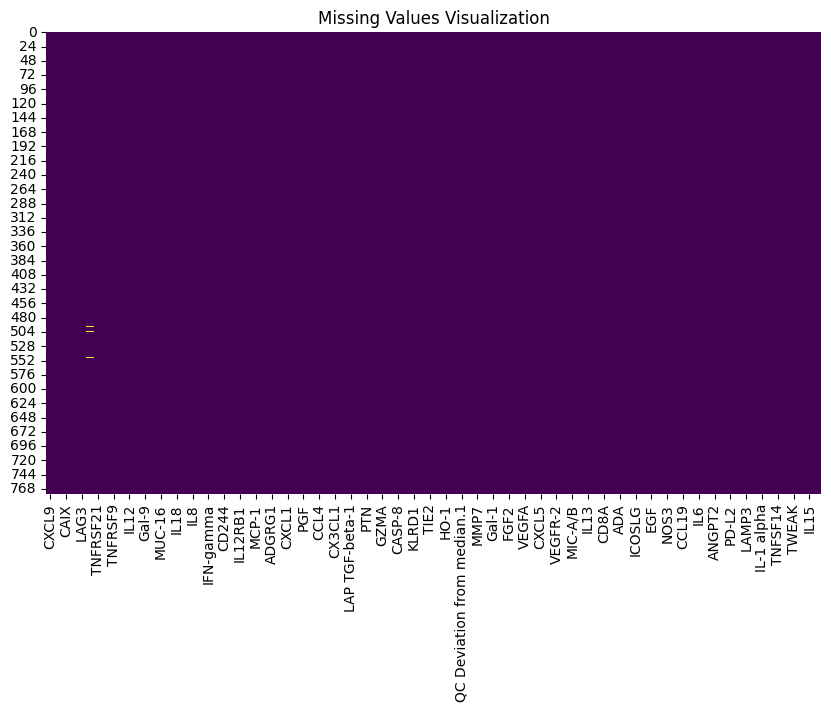

In [120]:
plt.figure(figsize=(10, 6))
sns.heatmap(concatenated_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Visualization")
plt.show()

In [121]:
df = df.drop(columns=['Sample ID','Agent (JNJ/BMS/Caribou)','Date of CAR-T infusion','Days in relation to CAR-T  infusion'
,'Patient experienced CRS at any point (Yes/No)','Best Response as of 1_24_2024'], axis=0)

df['Date of Sample'] = pd.to_datetime(df['Date of Sample'])

In [122]:
df

,Wearable Device ID,PT_ID,DOB,Age,Date of Sample,"CRS on date (0 No, 1 Yes)",CRS Grade,ICANS on date,"TOCI given on day (0 no, 1 yes)","Anakinra given on day (0 no, 1 yes)",...,"ICANs on date (0 -no, 1 yes)",Abs Monocyte,Abs Neutrophil,Abs Lymphocyte,Weight at time of infusion,Total Cells infused (x10^6),DOP,Date of last response assesment,Identifier,CRS
0,NaN,7001.0,1939-11-16,82.986301,2022-10-21,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7001.0,Yes
1,NaN,7001.0,1939-11-16,82.986301,2022-10-22,1.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7001.0,Yes
2,NaN,7001.0,1939-11-16,82.986301,2022-10-22,1.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7001.0,Yes
3,NaN,7001.0,1939-11-16,82.986301,2022-10-23,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7001.0,Yes
4,NaN,7001.0,1939-11-16,82.986301,2022-10-24,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7001.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,NaN,7030.0,NaT,NaN,2023-11-27,0.0,0.0,NaN,0.0,0.0,...,0.0,0.2484,0.15,1.728,76.6,53.62,NaN,1/30/2024,7030.0,Yes
430,NaN,7030.0,NaT,NaN,2023-11-28,0.0,0.0,NaN,0.0,0.0,...,0.0,0.3780,0.12,2.730,76.6,53.62,NaN,1/30/2024,7030.0,Yes
431,NaN,7030.0,NaT,NaN,2023-11-29,0.0,0.0,NaN,0.0,0.0,...,0.0,0.3600,0.19,1.080,76.6,53.62,NaN,1/30/2024,7030.0,Yes
432,NaN,7030.0,NaT,NaN,2023-11-30,0.0,0.0,NaN,0.0,0.0,...,0.0,0.4590,0.36,0.646,76.6,53.62,NaN,1/30/2024,7030.0,Yes


In [123]:
data =df 
grouped = data.groupby('PT_ID').apply(lambda x:x.sort_values("Date of Sample"))
data = data.apply(pd.to_numeric, errors='coerce')
grouped = grouped.reset_index(drop=True)
biomarker_columns = [col for col in data.columns if col not in ['PT_ID',"Date of Sample","CRS Grade",'CRS on date (0 No, 1 Yes)']]
biomarker_columns = ['IL6']
patients_data = [group[biomarker_columns].values for _, group in grouped.groupby('PT_ID')]



/var/folders/9q/_q_h4th94vj56dq6c3yv3gj80000gn/T/ipykernel_50269/1671731936.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = data.groupby('PT_ID').apply(lambda x:x.sort_values("Date of Sample"))


In [124]:
patients_data

[array([[4.75454],
        [6.62383],
        [6.70536],
        [12.08822],
        [12.06005],
        [10.11295],
        [8.78565],
        [8.41455],
        [8.85547],
        [8.79098],
        [8.90191],
        [10.95929]], dtype=object),
 array([[3.92939],
        [4.29395],
        [3.90488],
        [4.87621],
        [5.03164],
        [5.23761],
        [5.9185],
        [5.84745],
        [10.33626],
        [8.53225],
        [7.76603],
        [7.09284],
        [6.71909],
        [7.74172],
        [7.09481],
        [6.86619],
        [7.18041]], dtype=object),
 array([[4.70522],
        [4.94987],
        [4.93701],
        [7.19556],
        [7.6284],
        [12.14361],
        [10.78406],
        [9.16792],
        [8.87761],
        [8.36041],
        [7.99942],
        [7.56638],
        [7.59042],
        [7.7143],
        [7.95793],
        [8.18169],
        [8.32659],
        [7.63619],
        [7.73235]], dtype=object),
 array([[4.50905],
        [4.42806]

In [125]:
[patient.shape[0] for patient in patients_data]

[12,
 17,
 19,
 16,
 14,
 14,
 11,
 17,
 18,
 15,
 16,
 12,
 6,
 20,
 17,
 12,
 14,
 16,
 12,
 12,
 14,
 14,
 15,
 15,
 20,
 4,
 13,
 14,
 19,
 16]

In [126]:
min_length = 144
filtered_patients_data = [patient for patient in patients_data if patient.shape[0] >= min_length]

patients_data_truncated = [patient[:min_length, :] for patient in filtered_patients_data]

In [127]:
patient_data_normalized = []
for data_array in patients_data_truncated:
    baseline = data_array[0, 0]  # First element in the subarray as baseline
    normalized_array = data_array - baseline
    patient_data_normalized.append(normalized_array)

# Display the list of normalized arrays
patient_data_normalized

[]

In [128]:

import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans

# Assuming patient_data_normalized is a list of arrays, convert it to a 3D NumPy array
patient_data_normalized = np.array(patient_data_normalized)  # Make sure it's a 3D array

# Step 1: Clustering
n_clusters = 3  # Choose the number of clusters
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", max_iter=50, verbose=True, random_state=12)
labels = model.fit_predict(patient_data_normalized)

# Step 3: Visualize cluster assignments
for cluster_idx in range(n_clusters):
    plt.figure()
    for i, patient in enumerate(patient_data_normalized[labels == cluster_idx]):
        plt.plot(patient[:, 0])  # Plot the first biomarker for simplicity
    plt.title(f"Cluster {cluster_idx}")
    plt.show()

# Print cluster assignments for each patient
print("Cluster assignments:", labels)


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
from sklearn.metrics import silhouette_score

num_patients = patient_data_normalized.shape[0]

silhouette_avg = silhouette_score(patient_data_normalized.reshape(num_patients, -1), labels, metric="euclidean")
print(f"Silhouette Score: {silhouette_avg}")




Silhouette Score: 0.3378891574184081


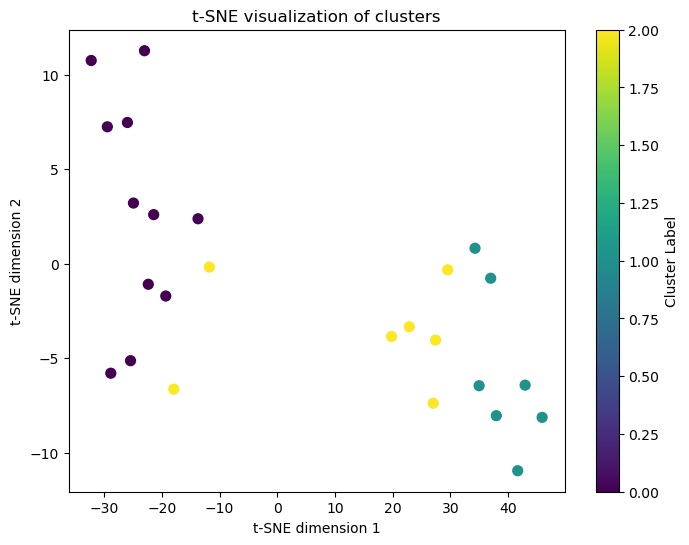

In [ ]:
from sklearn.manifold import TSNE
n_patients, n_time_steps, n_features = patient_data_normalized.shape


# Step 2: Apply t-SNE with appropriate perplexity
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
data_tsne = tsne.fit_transform(patient_data_normalized.reshape(num_patients, -1))

# Step 3: Plot the t-SNE embedding with cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap='viridis', s=50)
plt.title('t-SNE visualization of clusters')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [ ]:
import pandas as pd

# Step 6: Create a DataFrame to map filtered PT_IDs with cluster labels
label_df = pd.DataFrame({
    'PT_ID': filtered_pt_ids,
    'Cluster_Label': labels
})

data['PT_ID'] = data['PT_ID'].astype(str)
label_df['PT_ID'] = label_df['PT_ID'].astype(str)

# Step 7: Merge the label DataFrame back with the original dataset
data_with_labels = pd.merge(data, label_df, on='PT_ID', how='left')

# Check the dataset with cluster labels attached
print(data_with_labels.head())


   Date of Sample  Sample ID PT_ID  Agent (JNJ/BMS/Caribou)  \
0             NaN        NaN  7001                      NaN   
1             NaN        NaN  7001                      NaN   
2             NaN        NaN  7001                      NaN   
3             NaN        NaN  7001                      NaN   
4             NaN        NaN  7001                      NaN   

   Date of CAR-T infusion  Age  Days in relation to CAR-T  infusion  \
0                     NaN   83                                    0   
1                     NaN   83                                    0   
2                     NaN   83                                    0   
3                     NaN   83                                    0   
4                     NaN   83                                    0   

   Patient experienced CRS at any point (Yes/No)  CRS on date (0 No, 1 Yes)  \
0                                              1                          1   
1                                   

In [ ]:
label_df_Age = label_df.merge(df[['PT_ID','Patient experienced CRS at any point (Yes/No)','Age']],on="PT_ID",how='left').drop_duplicates()
label_df = label_df.merge(df[['PT_ID','Patient experienced CRS at any point (Yes/No)']],on="PT_ID",how='left').drop_duplicates()
df_Age = label_df_Age.groupby("PT_ID")['Age'].max().reset_index()
label_df = label_df.merge(df_Age, on="PT_ID")
label_df

,PT_ID,Cluster_Label,Patient experienced CRS at any point (Yes/No),Age
0,7001,2,1,83
1,7002,2,1,82
2,7003,1,1,68
3,7003,1,0,68
4,7004,0,0,67
5,7005,0,1,60
6,7005,0,0,60
7,7006,0,0,66
8,7007,1,1,69
9,7008,2,1,75


In [ ]:
len(label_df[label_df.Cluster_Label==0][label_df["Patient experienced CRS at any point (Yes/No)"]==1])

/var/folders/9q/_q_h4th94vj56dq6c3yv3gj80000gn/T/ipykernel_23325/3766631702.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(label_df[label_df.Cluster_Label==0][label_df["Patient experienced CRS at any point (Yes/No)"]==1])


8

In [ ]:
label_df[label_df.Cluster_Label==0]

,PT_ID,Cluster_Label,Patient experienced CRS at any point (Yes/No),Age
4,7004,0,0,67
5,7005,0,1,60
6,7005,0,0,60
7,7006,0,0,66
10,7009,0,1,76
14,7012,0,0,66
15,7013,0,1,73
16,7014,0,1,73
17,7014,0,0,73
20,7017,0,1,58


In [ ]:
label_df[label_df.Cluster_Label==1]

,PT_ID,Cluster_Label,Patient experienced CRS at any point (Yes/No),Age
2,7003,1,1,68
3,7003,1,0,68
8,7007,1,1,69
12,7011,1,1,67
13,7011,1,0,67
18,7015,1,0,58
19,7016,1,0,58
24,7020,1,1,58
25,7021,1,1,58


In [ ]:
label_df[label_df.Cluster_Label==2]

,PT_ID,Cluster_Label,Patient experienced CRS at any point (Yes/No),Age
0,7001,2,1,83
1,7002,2,1,82
9,7008,2,1,75
11,7010,2,1,68
23,7019,2,1,58
28,7024,2,1,58
29,7025,2,1,58


In [ ]:
label_df[label_df.Cluster_Label==0].Age.mean()

64.57142857142857

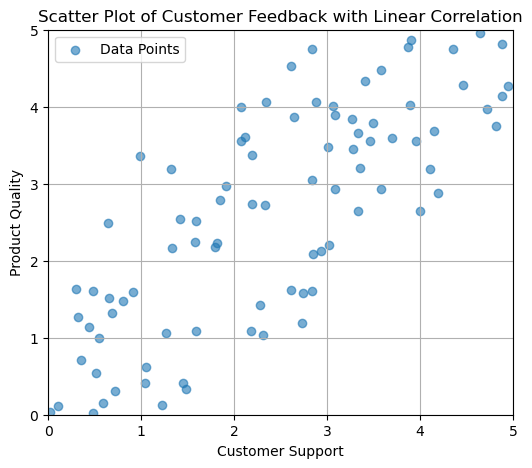

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
np.random.seed(0)

# Generate Customer Support data uniformly between 0 and 5
customer_support = np.random.uniform(0, 5, 100)

# Create Product Quality data with a linear relationship plus some noise
product_quality = 1 * customer_support + np.random.normal(0, 1, 100)  # Adjust slope and noise level

# Create scatter plot
plt.figure(figsize=(6, 5))
plt.scatter(customer_support, product_quality, alpha=0.6, label="Data Points")

# Set axis limits and labels
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel("Customer Support")
plt.ylabel("Product Quality")
plt.title("Scatter Plot of Customer Feedback with Linear Correlation")
plt.legend()

# Display plot
plt.grid(True)
plt.show()


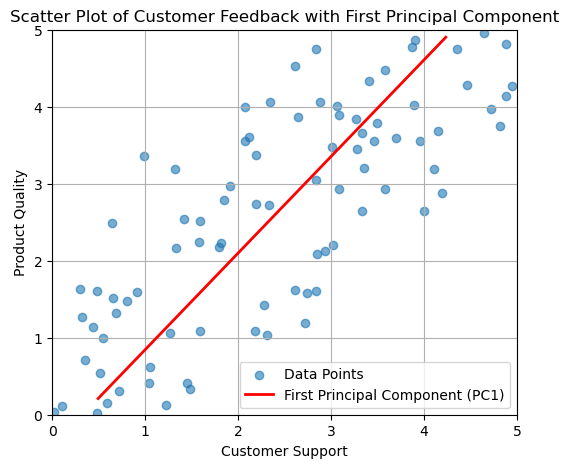

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Set random seed for reproducibility
np.random.seed(0)

# Generate Customer Support data uniformly between 0 and 5
customer_support = np.random.uniform(0, 5, 100)

# Create Product Quality data with a linear relationship plus some noise
product_quality = 1 * customer_support + np.random.normal(0, 1, 100)  # Adjust slope and noise level

# Combine data into a matrix for PCA
data = np.vstack((customer_support, product_quality)).T

# Apply PCA
pca = PCA(n_components=2)
pca.fit(data)

# Get the direction of the first principal component
pc1_direction = pca.components_[0]
pc1_center = pca.mean_

# Plot the data points
plt.figure(figsize=(6, 5))
plt.scatter(customer_support, product_quality, alpha=0.6, label="Data Points")

# Plot the first principal component
# Scale the direction vector for visualization
pc1_line_start = pc1_center - 3 * pc1_direction
pc1_line_end = pc1_center + 3 * pc1_direction
plt.plot([pc1_line_start[0], pc1_line_end[0]], [pc1_line_start[1], pc1_line_end[1]], color='red', linewidth=2, label="First Principal Component (PC1)")

# Set axis limits and labels
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel("Customer Support")
plt.ylabel("Product Quality")
plt.title("Scatter Plot of Customer Feedback with First Principal Component")
plt.legend()

# Display plot
plt.grid(True)
plt.show()


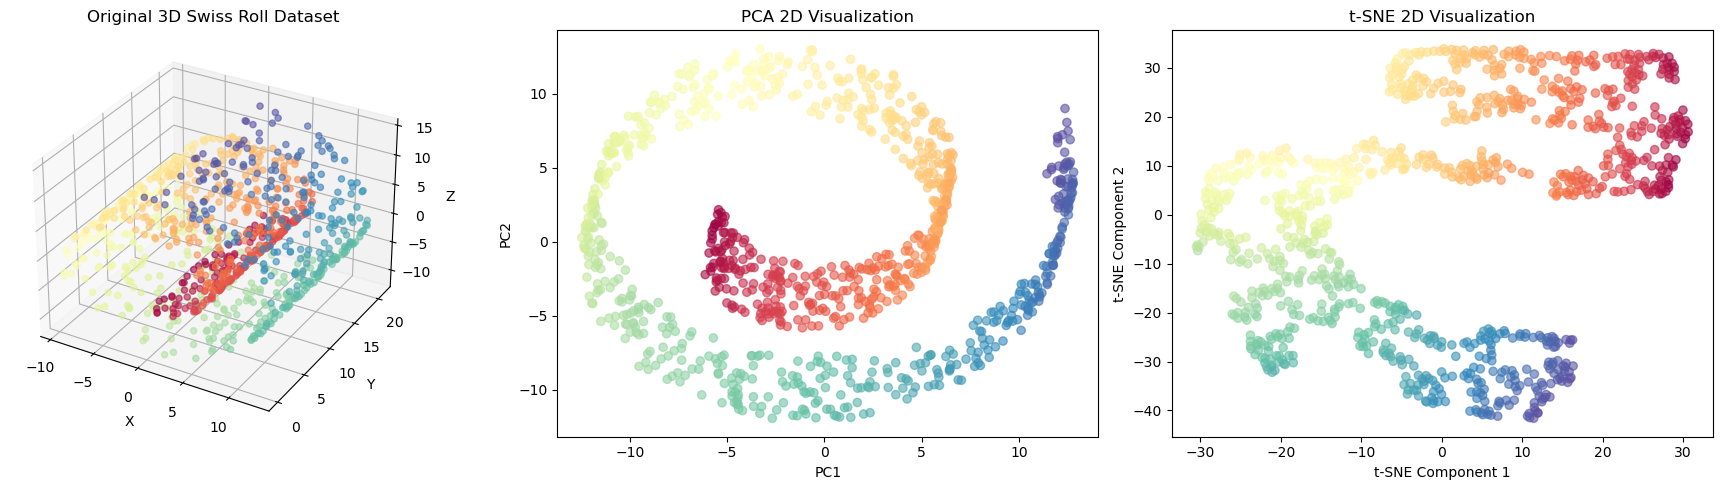

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import make_swiss_roll

# Generate the Swiss Roll dataset
n_samples = 1000
data, color = make_swiss_roll(n_samples, noise=0.05)
df = data[:, [0, 2]]  # We will use these as two of our 'features' for PCA and t-SNE

# Plot the original dataset in 3D to show the Swiss Roll structure
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color, cmap='Spectral', alpha=0.6)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("Original 3D Swiss Roll Dataset")

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

plt.subplot(1, 3, 2)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=color, cmap='Spectral', alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D Visualization")

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(data)

plt.subplot(1, 3, 3)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=color, cmap='Spectral', alpha=0.6)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE 2D Visualization")

# Display all plots
plt.tight_layout()
plt.show()


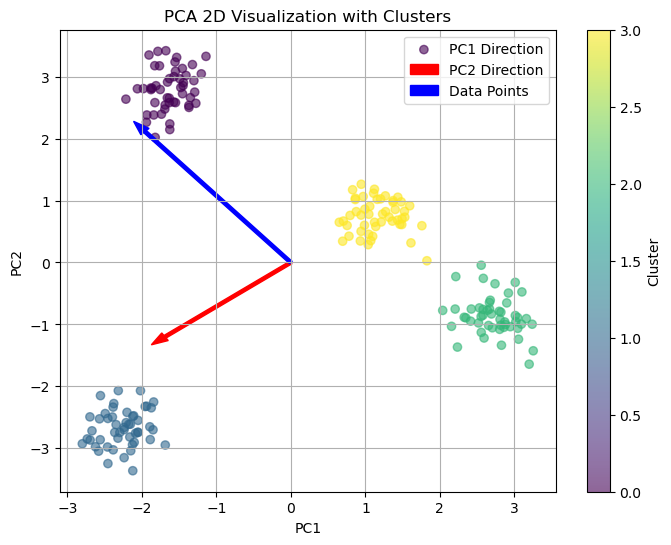

PCA Loadings for PC1: [-0.56295122 -0.3997341   0.67045272  0.27164634]
PCA Loadings for PC2: [-0.65262448  0.70495293 -0.20401716  0.1884135 ]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Set random seed for reproducibility
np.random.seed(0)

# Generate synthetic data for four clusters
cluster_1 = np.random.normal(loc=[1, 5, 1, 1], scale=0.3, size=(50, 4))  # Bottom-left
cluster_2 = np.random.normal(loc=[5, 1, 1, 1], scale=0.3, size=(50, 4))  # Bottom-right
cluster_3 = np.random.normal(loc=[1, 1, 5, 1], scale=0.3, size=(50, 4))  # Top-left
cluster_4 = np.random.normal(loc=[1, 1, 1, 5], scale=0.3, size=(50, 4))  # Top-right

# Combine the clusters into a single dataset
data = np.vstack([cluster_1, cluster_2, cluster_3, cluster_4])
labels = np.array([0]*50 + [1]*50 + [2]*50 + [3]*50)  # Labels for each cluster

# Create a DataFrame with the features and cluster labels
df = pd.DataFrame(data, columns=['Product Quality', 'Shipping Speed', 'Customer Support', 'Value for Money'])
df['Cluster'] = labels

# Apply PCA to reduce the data to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[['Product Quality', 'Shipping Speed', 'Customer Support', 'Value for Money']])

# Plot the PCA result
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D Visualization with Clusters")

# Plot the principal component directions
pc1 = pca.components_[0]  # First principal component
pc2 = pca.components_[1]  # Second principal component

# Scale components for plotting
pc1_line = 3 * np.array([pc1[0], pc1[1]])  # Scale for visualization
pc2_line = 3 * np.array([pc2[0], pc2[1]])  # Scale for visualization

plt.arrow(0, 0, pc1_line[0], pc1_line[1], color='red', width=0.05, label='PC1')
plt.arrow(0, 0, pc2_line[0], pc2_line[1], color='blue', width=0.05, label='PC2')
plt.legend(['PC1 Direction', 'PC2 Direction', 'Data Points'])

plt.grid(True)
plt.show()

# Show PCA loadings
print("PCA Loadings for PC1:", pca.components_[0])
print("PCA Loadings for PC2:", pca.components_[1])


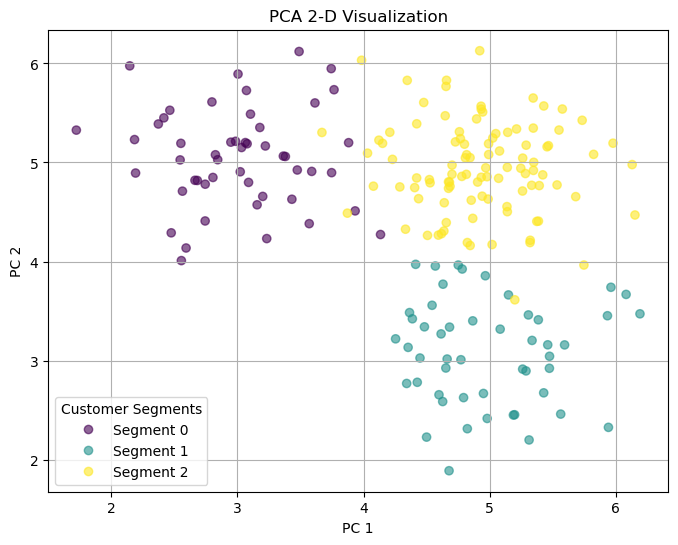

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

# Generate two clusters directly in 2D
# Cluster 1: Top-left quadrant
cluster_1 = np.random.normal(loc=[3, 5], scale=0.5, size=(50, 2))

# Cluster 2: Bottom-right quadrant
cluster_2 = np.random.normal(loc=[5, 3], scale=0.5, size=(50, 2))

cluster_3 = np.random.normal(loc=[5, 5], scale=0.5, size=(100, 2))

# Combine clusters into a single dataset
data = np.vstack([cluster_1, cluster_2, cluster_3])
labels = np.array([0]*50 + [1]*50 + [2]*100)  # Label each cluster

# Plot the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA 2-D Visualization")

# Add legend for clusters
plt.legend(handles=scatter.legend_elements()[0], labels=['Segment 0', 'Segment 1', 'Segment 2'], title="Customer Segments")
plt.grid(True)
plt.show()
